In [10]:
import pyart
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import os
from netCDF4 import num2date, date2num
from optparse import OptionParser
import sys 
import glob
import gc
from pyproj import Proj, Geod
import h5py

%matplotlib notebook

### Ängelholm radar
file1_ang_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/seang-PPIVol-20190613-010000-4b6d.hdf' 
file2_ang_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/seang-PPIVol-20190613-010103-4b73.hdf' 
file1_ang_8bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_8bit/seang-PPIVol-20190613-010000-4c6e.hdf' 
file2_ang_8bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_8bit/seang-PPIVol-20190613-010103-4c6f.hdf' 

### Bålsta radar
file1_baa_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/sebaa-PPIVol-20190613-030000-4b69.hdf' 

### Hemse radar
file1_hem_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/sehem-PPIVol-20190613-010000-4b6b.hdf'
file2_hem_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/sehem-PPIVol-20190613-010104-4b6e.hdf'
file1_hem_8bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_8bit/sehem-PPIVol-20190613-010000-4c76.hdf'
file2_hem_8bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_8bit/sehem-PPIVol-20190613-010104-4c74.hdf'

### Karlskrona radar
file1_kaa_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/sekaa-PPIVol-20190613-010000-4b6a.hdf'
file2_kaa_16bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_16bit/sekaa-PPIVol-20190613-010106-4b6c.hdf'
file1_kaa_8bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_8bit/sekaa-PPIVol-20190613-010000-4c73.hdf'
file2_kaa_8bit= '/data/proj/radar/edge/unfiltered/odimh5v2_2_eec_8bit/sekaa-PPIVol-20190613-010106-4c70.hdf'

In [11]:
## Help methods, if needed
# Method to calculate radius at given latitude
def radius_at_latitude(geod, lat):
    a = np.cos(lat*np.pi/180) * geod.a # equator radius
    b = np.sin(lat*np.pi/180) * geod.b # polar radius
    return np.sqrt(a**2 + b**2)

# Method to calculate ground distance and height from slant range and elevation
def re2dh(r, elev, h0=0, R=6378137.0, dndh=-3.9e-8):
    ''' from Baltrad's PolarNavigator
    void PolarNavigator_reToDh(PolarNavigator_t* polnav, double r, double e, double* d, double* h)
    {
      double R_prim = 0.0L, A_prim = 0.0L, B_prim = 0.0L, Lambda_prim = 0.0L, R_earth = 0.0L;

      RAVE_ASSERT((polnav != NULL), "polnav was NULL");
      RAVE_ASSERT((d != NULL && h != NULL), "d and/or h missing");

      R_earth = PolarNavigator_getEarthRadiusOrigin(polnav);

      if (abs(polnav->dndh + 1.0 / R_earth) < 1.0e-9 * (polnav->dndh)) {
        /*Straight lines*/
        *h = polnav->alt0 + r * sin(e);
        *d = r * cos(e);
        return;
      }

      R_prim = 1.0 / ((1.0 / R_earth) + polnav->dndh);
      A_prim = R_prim + polnav->alt0 + r * sin(e);
      B_prim = r * cos(e);
      Lambda_prim = atan(B_prim / (A_prim));
      *h = sqrt(A_prim * A_prim + B_prim * B_prim) - R_prim;
      *d = R_prim * Lambda_prim;
    }
    '''
    elev = elev * np.pi/180 # to radians
    R_prim = 1.0 / (1.0/R + dndh)
    A_prim = R_prim + h0 +  r * np.sin(elev)
    B_prim = r * np.cos(elev)
    Lambda_prim = np.arctan(B_prim/A_prim)
    h = np.sqrt(A_prim**2 + B_prim**2) - R_prim
    d = R_prim * Lambda_prim
    return d, h

In [12]:
def extract_mom(file,ele,mom):
    '''To extract a moment at a certain elevation (sweep) from hdf file'''
    ## Open 'file' and get some attribute values
    f = h5py.File(file, 'r')

    lat = f['where'].attrs['lat']
    lon = f['where'].attrs['lon']
    height = f['where'].attrs['height']

    nbins = f[ele]['where'].attrs['nbins']
    nrays = f[ele]['where'].attrs['nrays']
    rscale = f[ele]['where'].attrs['rscale']
    rstart = f[ele]['where'].attrs['rstart']
    elangle = f[ele]['where'].attrs['elangle']

    startazA = f[ele]['how'].attrs['startazA']

    # get the matrix of the dataset values 
    values = f[ele][mom]['data'].value

    # some useful things that go with the data
    gain = f[ele][mom]['what'].attrs['gain']
    offset = f[ele][mom]['what'].attrs['offset']
    nodata = f[ele][mom]['what'].attrs['nodata']
    undetect = f[ele][mom]['what'].attrs['undetect']
    
    #convert array to float and assign NaN to undetect and nodata
    values=values*1.0
    values[(values==undetect) | (values==nodata)]= np.nan
    
    # compute the quantity's actual data values
    data = values * gain + offset
    
    ## Method to create the coordinates to transform the polar dataset
    # create a geod
    geod = Geod(ellps='WGS84')

    # lets use real numbers instead; startazA and ground distance!
    theta = startazA * np.pi / 180 + np.pi/2 # start at North, not along x axis
    theta = np.append(theta, theta[0]) # let last and first value be the same
    theta = theta[::-1] # flip array to go clockwise
    radii = np.linspace(rstart, rscale*nbins, nbins+1) # slant ranges
    elevs = np.full(radii.shape, elangle) # elevation values to match radii
    radii, h = re2dh(radii, elevs, h0=height, R=radius_at_latitude(geod, lat)) 

    ## Tranform
    # create mesh of coordinates
    Radii, Theta = np.meshgrid(radii, theta)

    # transform coordinates
    X = Radii * np.cos(Theta)
    Y = Radii * np.sin(Theta)
    
    return X, Y, data



def allelev_mom(file,mom):
    '''To extract the total distribution of a moment from all the sweeps.
    It aso calcuates the .25, .50 and .75 quantiles of the distribution of themoment for each sweep'''
    mom_tot=[]
    quant= np.zeros((10,3))
    for i in range(1,11):
        ds= 'dataset{}'.format(i)
        [X, Y, data] = extract_mom(file,ds,mom)
        mom_tot= np.concatenate((mom_tot,data.flatten()))
        quant[i-1,:]= np.nanpercentile(data, [25, 50, 75])  
        
    return mom_tot, quant

### LDR files from ANG
#### TH and DBZH from first elevation

In [13]:
## Select file and dataset groups
# define some suitable file path...
#LDR files from ANG 
fstr1 = file1_ang_16bit
fstr2= file1_ang_8bit
# dataset corresponds to the elevation
ele1 = 'dataset1'
# data corresponds to the quantity
th = 'data1'
dbzh = 'data2'

[X_16, Y_16, data_th_16] = extract_mom(fstr1,ele1,th)
[lon_16, lat_16, data_dbzh_16] = extract_mom(fstr1,ele1,dbzh)
[X_8, Y_8, data_th_8] = extract_mom(fstr2,ele1,th)
[X_8, Y_8, data_dbzh_8] = extract_mom(fstr2,ele1,dbzh)

<IPython.core.display.Javascript object>


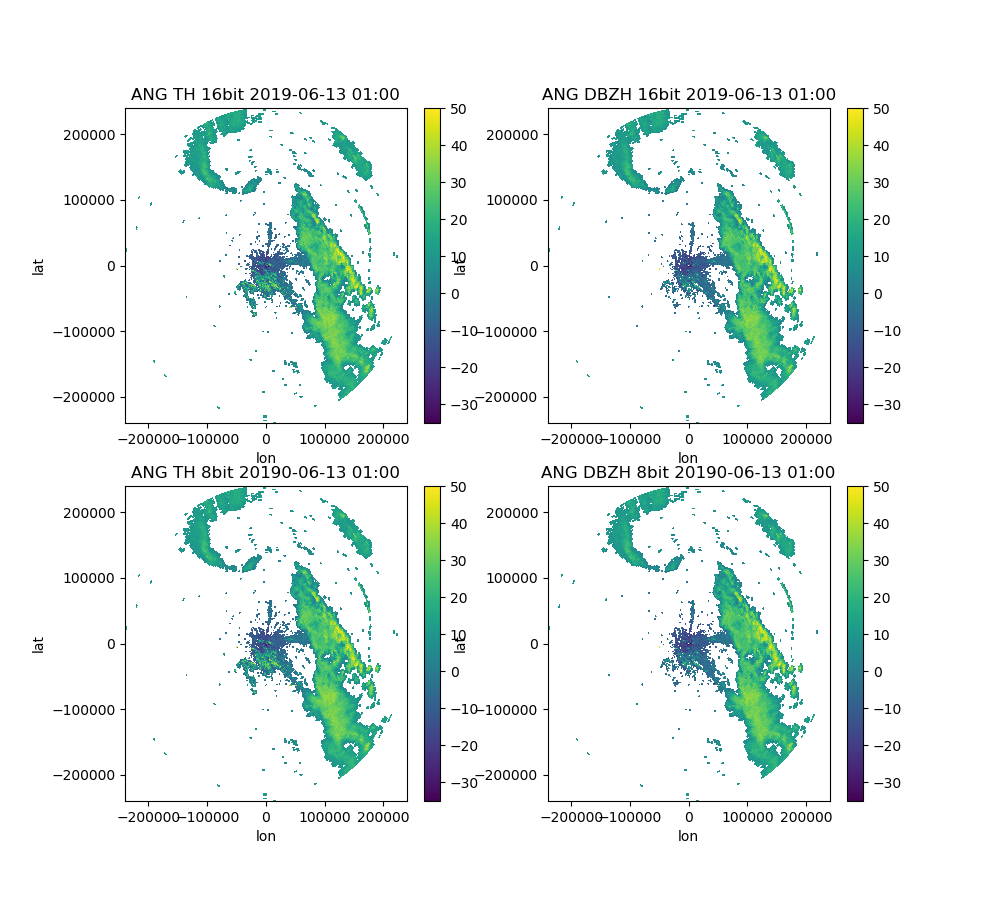

Text(0.5, 1.0, 'ANG DBZH 8bit 20190-06-13 01:00')

In [16]:
plt.figure(figsize=(10,9))

plt.subplot(2,2,1)
plt.pcolormesh(X_16, Y_16, data_th_16, vmin=-35, vmax=50)
plt.colorbar()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ANG TH 16bit 2019-06-13 01:00')

plt.subplot(2,2,2)
plt.pcolormesh(X_16, Y_16, data_dbzh_16, vmin=-35, vmax=50)
plt.colorbar()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ANG DBZH 16bit 2019-06-13 01:00')

plt.subplot(2,2,3)
plt.pcolormesh(X_8, Y_8, data_th_8, vmin=-35, vmax=50)
plt.colorbar()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ANG TH 8bit 20190-06-13 01:00')

plt.subplot(2,2,4)
plt.pcolormesh(X_8, Y_8, data_dbzh_8, vmin=-35, vmax=50)
plt.colorbar()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ANG DBZH 8bit 20190-06-13 01:00')


### ZDR files from ANG
#### Data from all elevations

In [17]:
#TH and DBZH
file_16= file2_ang_16bit
file_8= file2_ang_8bit
th='data1'
dbzh='data2'

[TH_16_tot, quant_TH_16]=allelev_mom(file_16,th)
[DBZH_16_tot, quant_DBZH_16]=allelev_mom(file_16,dbzh)
[TH_8_tot, quant_TH_8]=allelev_mom(file_8,th)
[DBZH_8_tot, quant_DBZH_8]=allelev_mom(file_8,dbzh)

<IPython.core.display.Javascript object>


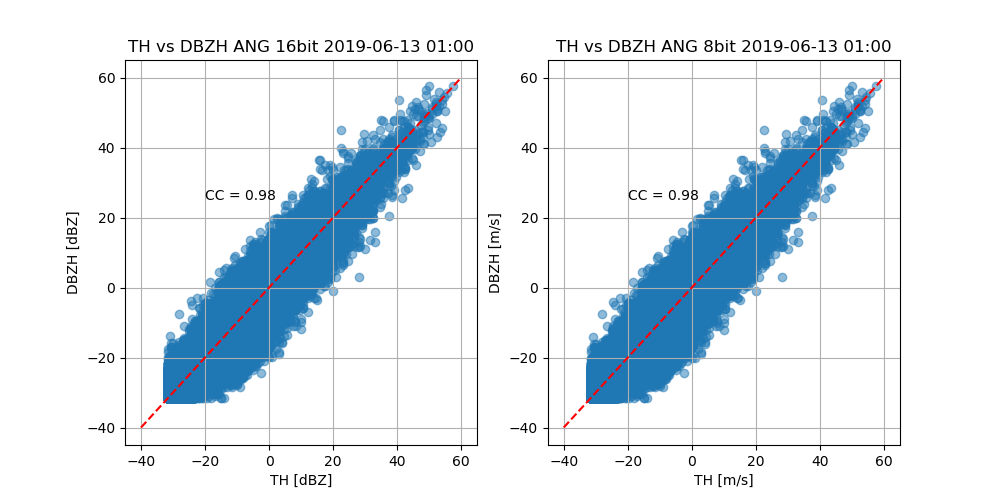

Text(-20, 25, 'CC = 0.98')

In [18]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(TH_16_tot, DBZH_16_tot, alpha=0.5)
plt.grid()
plt.plot([-40,60],[-40,60],'r--')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH ANG 16bit 2019-06-13 01:00')
a=TH_16_tot
b=DBZH_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))

plt.subplot(1,2,2)
plt.scatter(TH_8_tot, DBZH_8_tot, alpha=0.5)
plt.grid()
plt.plot([-40,60],[-40,60],'r--')
plt.xlabel('TH [m/s]')
plt.ylabel('DBZH [m/s]')
plt.title('TH vs DBZH ANG 8bit 2019-06-13 01:00')
a=TH_8_tot
b=DBZH_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))

<IPython.core.display.Javascript object>


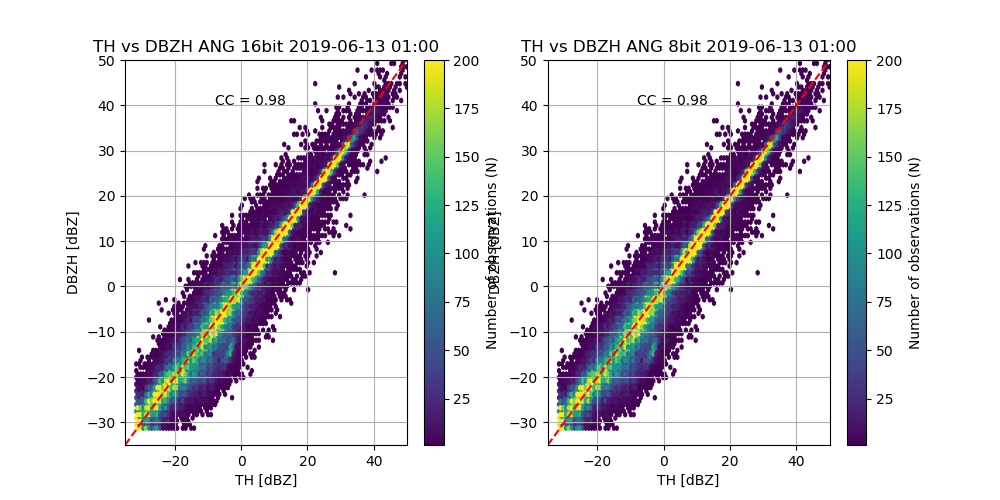

Text(-8, 40, 'CC = 0.98')

In [19]:
%matplotlib notebook

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hexbin(TH_16_tot,DBZH_16_tot, mincnt=0.1,gridsize=100,extent=(-35,50,-35,50),vmax=200)
plt.grid()
plt.plot([-35,50],[-35,50],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH ANG 16bit 2019-06-13 01:00')
a=TH_16_tot
b=DBZH_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))

plt.subplot(1,2,2)
plt.hexbin(TH_8_tot,DBZH_8_tot, mincnt=0.1,gridsize=100,extent=(-35,50,-35,50),vmax=200)
plt.grid()
plt.plot([-35,50],[-35,50],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH ANG 8bit 2019-06-13 01:00')
a=TH_8_tot
b=DBZH_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))


<IPython.core.display.Javascript object>


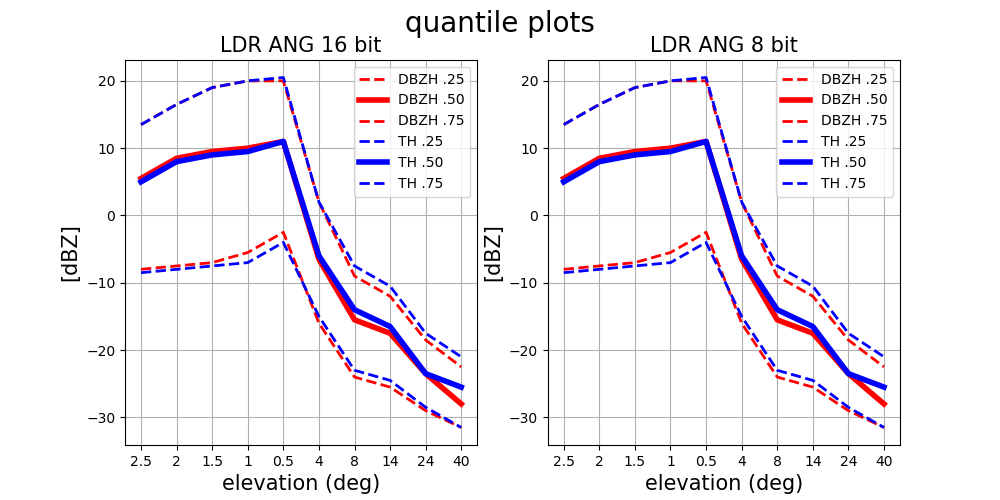

([<matplotlib.axis.XTick at 0x7faef2dd6898>,
 <a list of 10 Text xticklabel objects>)

In [131]:
plt.figure(figsize=(10,5))

range_interval=[1,2,3,4,5,6,7,8,9,10]

plt.subplot(1,2,1)
plt.plot(range_interval,quant_DBZH_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_DBZH_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_DBZH_16[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_TH_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_TH_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_TH_16[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dBZ]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=17)
plt.title('LDR ANG 16 bit', fontsize=15)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
labels=['2.5','2','1.5','1','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(1,2,2)
plt.plot(range_interval,quant_DBZH_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_DBZH_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_DBZH_8[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_TH_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_TH_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_TH_8[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dBZ]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=20)
plt.title('LDR ANG 8 bit', fontsize=15)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
plt.xticks(range(1,11),labels)
#plt.yscale('log')


In [20]:
#VRADH and UVRADH
file_16 = file2_ang_16bit
file_8= file2_ang_8bit
d1='data23' #UVRADH
d2='data14' #VRADH

[uv_16_tot, quant_uv_16]=allelev_mom(file_16,d1)
[v_16_tot, quant_v_16]=allelev_mom(file_16,d2)

[uv_8_tot, quant_uv_8]=allelev_mom(file_8,d1)
[v_8_tot, quant_v_8]=allelev_mom(file_8,d2)

<IPython.core.display.Javascript object>


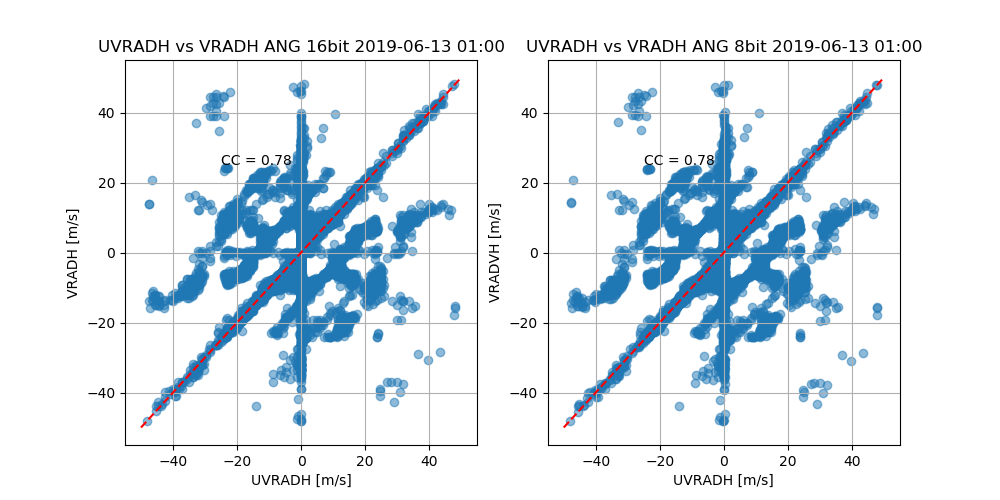

Text(-25, 25, 'CC = 0.78')

In [21]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(uv_16_tot, v_16_tot, alpha=0.5)
plt.grid()
plt.plot([-50,50],[-50,50],'r--')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH ANG 16bit 2019-06-13 01:00')
a=uv_16_tot
b=v_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-25,25))


plt.subplot(1,2,2)
plt.scatter(uv_8_tot, v_8_tot, alpha=0.5)
plt.grid()
plt.plot([-50,50],[-50,50],'r--')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADVH [m/s]')
plt.title('UVRADH vs VRADH ANG 8bit 2019-06-13 01:00')
a=uv_8_tot
b=v_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-25,25))

<IPython.core.display.Javascript object>


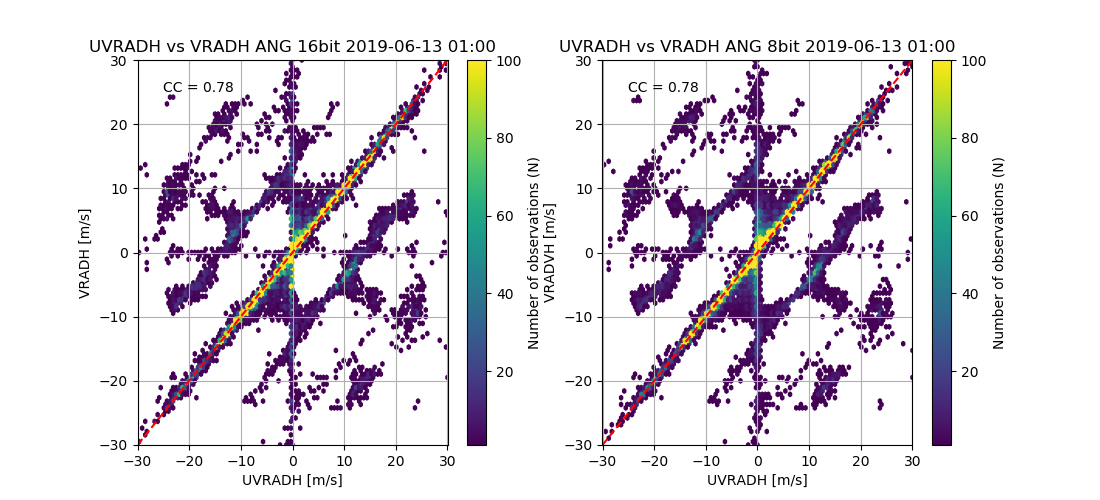

Text(-25, 25, 'CC = 0.78')

In [22]:
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.hexbin(uv_16_tot,v_16_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH ANG 16bit 2019-06-13 01:00')
a=uv_16_tot
b=v_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-25,25))


plt.subplot(1,2,2)
plt.hexbin(uv_8_tot,v_8_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADVH [m/s]')
plt.title('UVRADH vs VRADH ANG 8bit 2019-06-13 01:00')
a=uv_8_tot
b=v_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-25,25))

<IPython.core.display.Javascript object>


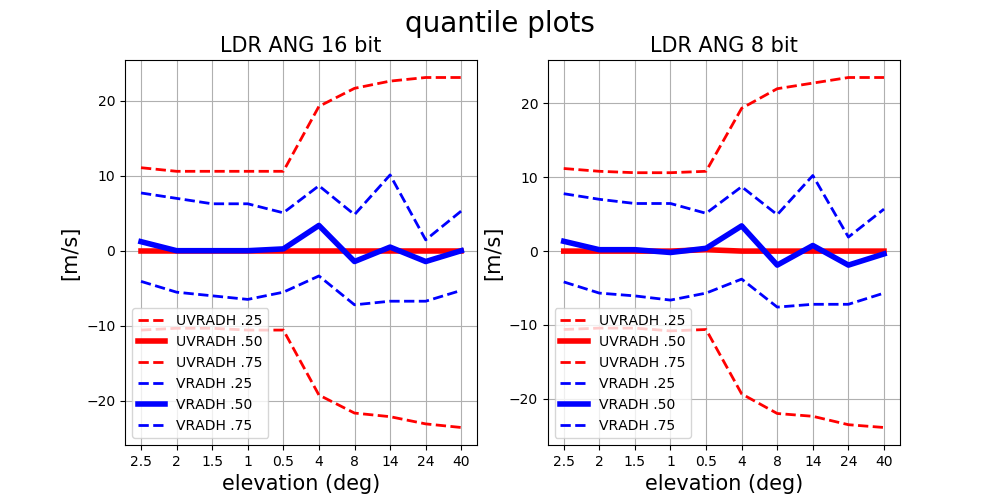

([<matplotlib.axis.XTick at 0x7f8947435080>,
 <a list of 10 Text xticklabel objects>)

In [23]:
plt.figure(figsize=(10,5))

range_interval=[1,2,3,4,5,6,7,8,9,10]

plt.subplot(1,2,1)
plt.plot(range_interval,quant_uv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_16[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_v_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_16[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=17)
plt.title('LDR ANG 16 bit', fontsize=15)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
labels=['2.5','2','1.5','1','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(1,2,2)
plt.plot(range_interval,quant_uv_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_8[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_v_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_8[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=20)
plt.title('LDR ANG 8 bit', fontsize=15)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
plt.xticks(range(1,11),labels)

In [24]:
#WRADH and UWRADH
file_16 = file2_ang_16bit
file_8= file2_ang_8bit
d1='data25' #UWRADH
d2='data16' #WRADH

[uw_16_tot, quant_uw_16]=allelev_mom(file_16,d1)
[w_16_tot, quant_w_16]=allelev_mom(file_16,d2)

[uw_8_tot, quant_uw_8]=allelev_mom(file_8,d1)
[w_8_tot, quant_w_8]=allelev_mom(file_8,d2)

<IPython.core.display.Javascript object>


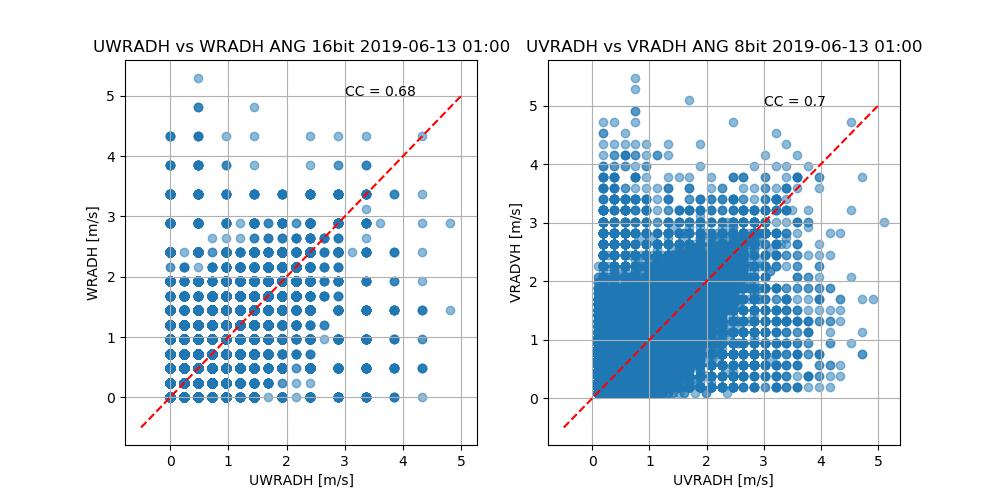

Text(3, 5, 'CC = 0.7')

In [25]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(uw_16_tot, w_16_tot, alpha=0.5)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
#plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADH [m/s]')
plt.title('UWRADH vs WRADH ANG 16bit 2019-06-13 01:00')
a=uw_16_tot
b=w_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,5))


plt.subplot(1,2,2)
plt.scatter(uw_8_tot, w_8_tot, alpha=0.5)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
#plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADVH [m/s]')
plt.title('UVRADH vs VRADH ANG 8bit 2019-06-13 01:00')
a=uw_8_tot
b=w_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,5))

<IPython.core.display.Javascript object>


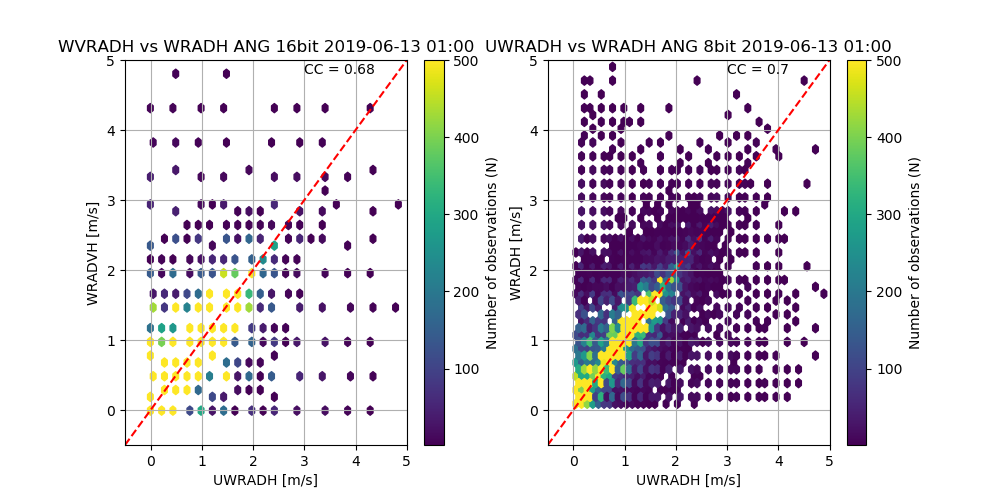

Text(3, 4.8, 'CC = 0.7')

In [26]:
%matplotlib notebook

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hexbin(uw_16_tot,w_16_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADVH [m/s]')
plt.title('WVRADH vs WRADH ANG 16bit 2019-06-13 01:00')
a=uw_16_tot
b=w_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))

plt.subplot(1,2,2)
plt.hexbin(uw_8_tot,w_8_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADH [m/s]')
plt.title('UWRADH vs WRADH ANG 8bit 2019-06-13 01:00')
a=uw_8_tot
b=w_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))

<IPython.core.display.Javascript object>


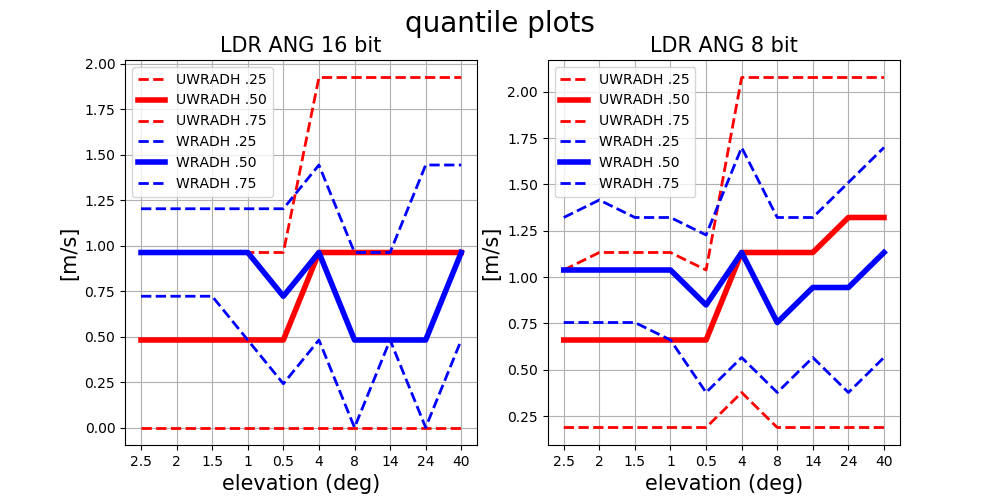

([<matplotlib.axis.XTick at 0x7f8947124278>,
 <a list of 10 Text xticklabel objects>)

In [27]:
plt.figure(figsize=(10,5))

range_interval=[1,2,3,4,5,6,7,8,9,10]
#range_inteval=[2.5,2,1.5,1,0.5,4,8,14,24,40]

plt.subplot(1,2,1)
plt.plot(range_interval,quant_uw_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_16[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_w_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_16[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=17)
plt.title('LDR ANG 16 bit', fontsize=15)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
labels=['2.5','2','1.5','1','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(1,2,2)
plt.plot(range_interval,quant_uw_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_8[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_w_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_8[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=20)
plt.title('LDR ANG 8 bit', fontsize=15)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
plt.xticks(range(1,11),labels)

In [28]:
#ZDR and UZDR
file_16 = file2_ang_16bit
file_8= file2_ang_8bit
d1='data18' #UZDR
d2='data5' #ZDR

[uzdr_16_tot, quant_uzdr_16]=allelev_mom(file_16,d1)
[zdr_16_tot, quant_zdr_16]=allelev_mom(file_16,d2)

[uzdr_8_tot, quant_uzdr_8]=allelev_mom(file_8,d1)
[zdr_8_tot, quant_zdr_8]=allelev_mom(file_8,d2)

<IPython.core.display.Javascript object>


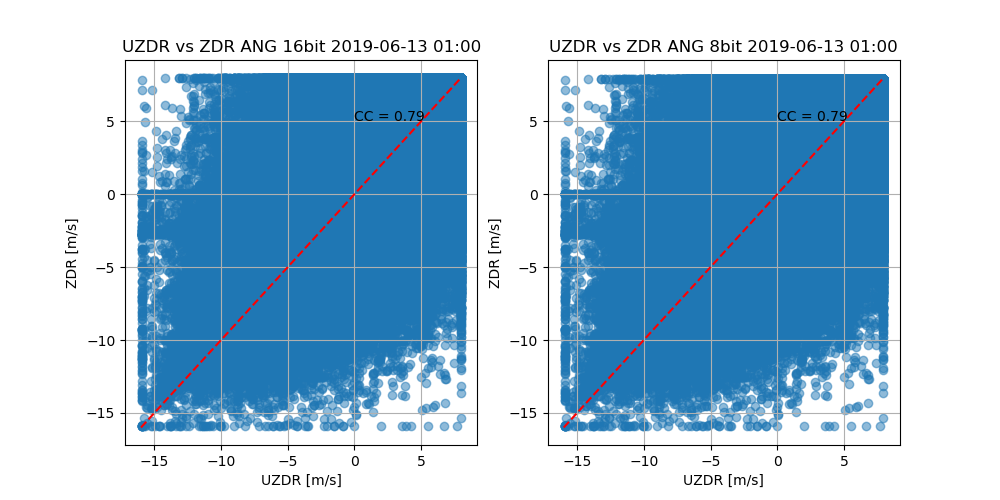

Text(0, 5, 'CC = 0.79')

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(uzdr_16_tot, zdr_16_tot, alpha=0.5)
plt.grid()
plt.plot([-16,8],[-16,8],'r--')
#plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR ANG 16bit 2019-06-13 01:00')
a=uzdr_16_tot
b=zdr_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,5))


plt.subplot(1,2,2)
plt.scatter(uzdr_8_tot, zdr_8_tot, alpha=0.5)
plt.grid()
plt.plot([-16,8],[-16,8],'r--')
#plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR ANG 8bit 2019-06-13 01:00')
a=uzdr_8_tot
b=zdr_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,5))

<IPython.core.display.Javascript object>


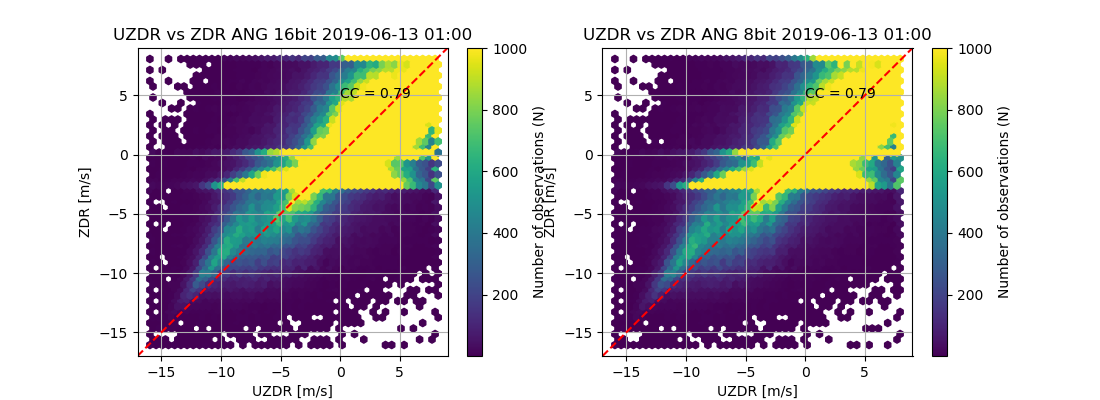

Text(0, 4.8, 'CC = 0.79')

In [30]:
%matplotlib notebook

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.hexbin(uzdr_16_tot,zdr_16_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR ANG 16bit 2019-06-13 01:00')
a=uzdr_16_tot
b=zdr_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))

plt.subplot(1,2,2)
plt.hexbin(uzdr_8_tot,zdr_8_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR ANG 8bit 2019-06-13 01:00')
a=uzdr_8_tot
b=zdr_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))

<IPython.core.display.Javascript object>


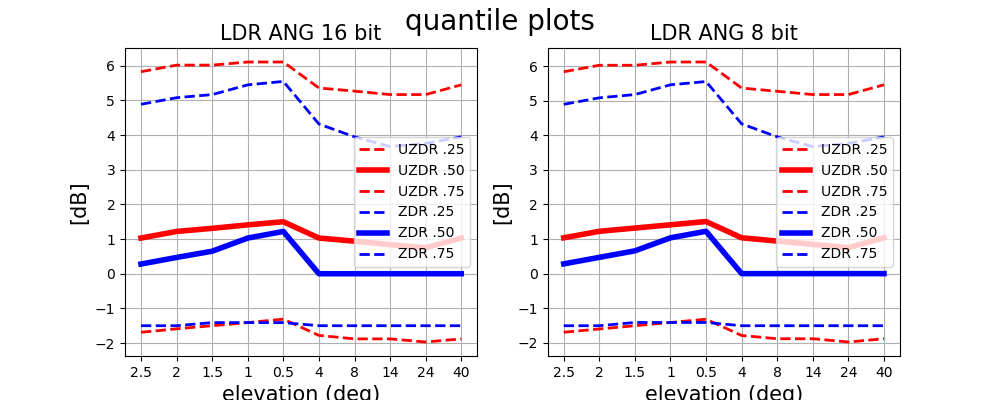

([<matplotlib.axis.XTick at 0x7f89453dbe48>,
 <a list of 10 Text xticklabel objects>)

In [31]:
plt.figure(figsize=(10,4))

range_interval=[1,2,3,4,5,6,7,8,9,10]

plt.subplot(1,2,1)
plt.plot(range_interval,quant_uzdr_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_16[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_zdr_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_16[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=17)
plt.title('LDR ANG 16 bit', fontsize=15)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
labels=['2.5','2','1.5','1','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(1,2,2)
plt.plot(range_interval,quant_uzdr_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_8[:,2],'--r',linewidth=2)

plt.plot(range_interval,quant_zdr_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_8[:,2],'--b',linewidth=2)

plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)

plt.suptitle('quantile plots', fontsize=20)
plt.title('LDR ANG 8 bit', fontsize=15)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
plt.xticks(range(1,11),labels)

In [32]:
#URHOHV and RHOHV
file_16 = file2_ang_16bit
file_8= file2_ang_8bit
d1='data19' #URHOHV
d2='data6' #RHOHV

[urhohv_16_tot, quant_urhohv_16]=allelev_mom(file_16,d1)
[rhohv_16_tot, quant_rhohv_16]=allelev_mom(file_16,d2)

[urhohv_8_tot, quant_urhohv_8]=allelev_mom(file_8,d1)
[rhohv_8_tot, quant_rhohv_8]=allelev_mom(file_8,d2)

<IPython.core.display.Javascript object>


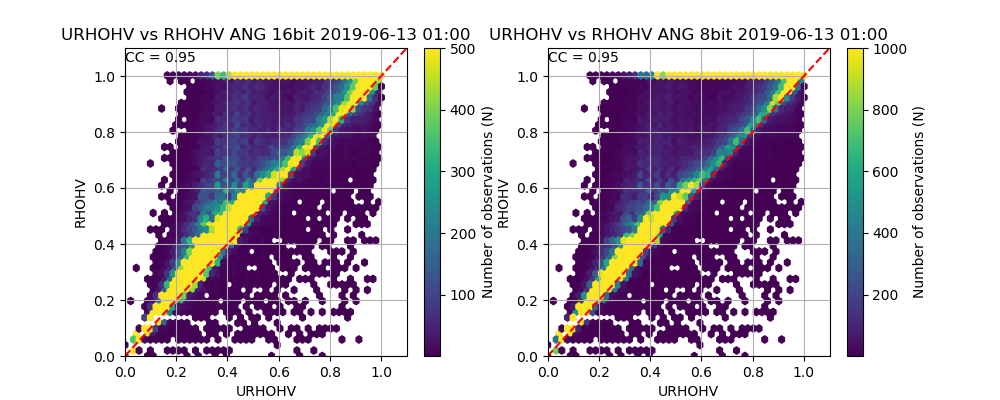

Text(0, 1.05, 'CC = 0.95')

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hexbin(urhohv_16_tot,rhohv_16_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=500)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV ANG 16bit 2019-06-13 01:00')
a=urhohv_16_tot
b=rhohv_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))


plt.subplot(1,2,2)
plt.hexbin(urhohv_8_tot,rhohv_8_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=1000)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV ANG 8bit 2019-06-13 01:00')
a=urhohv_8_tot
b=rhohv_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))

<IPython.core.display.Javascript object>


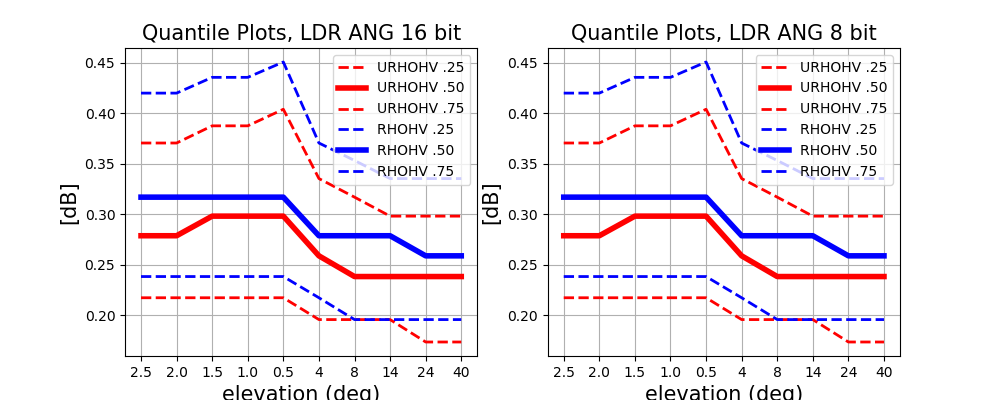

([<matplotlib.axis.XTick at 0x7f894512e1d0>,
 <a list of 10 Text xticklabel objects>)

In [34]:
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
plt.plot(range_interval,quant_urhohv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR ANG 16 bit', fontsize=15)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(1,2,2)
plt.plot(range_interval,quant_urhohv_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR ANG 8 bit', fontsize=15)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)

<IPython.core.display.Javascript object>


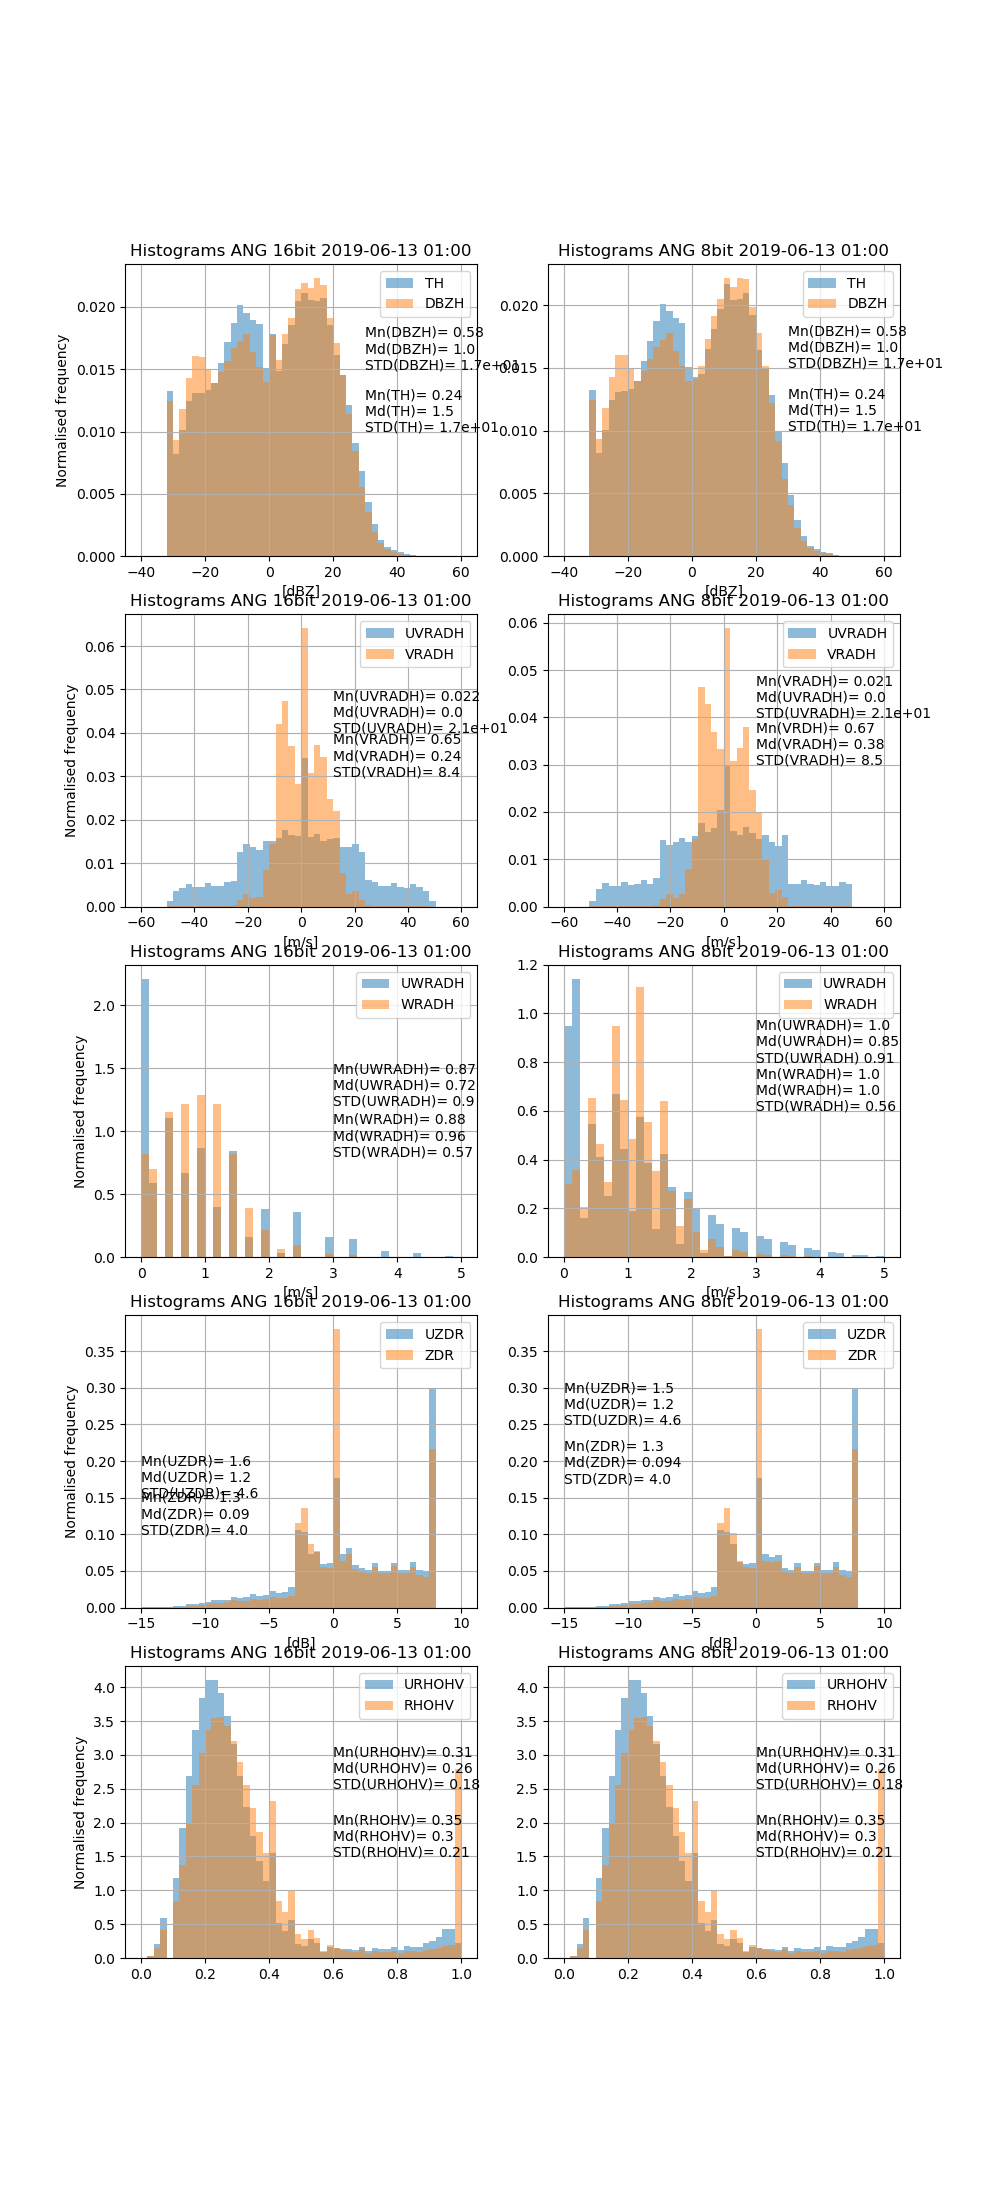

In [37]:
#plotting histograms of the moments
plt.figure(figsize=(10,22))

plt.subplot(5,2,1)
plt.hist(TH_16_tot, bins=50, alpha=0.5, range=(-40,60),normed=True)
plt.hist(DBZH_16_tot, bins=50, alpha=0.5, range=(-40,60),normed=True)
plt.grid()
plt.xlabel('[dBZ]')
plt.ylabel('Normalised frequency')
plt.title('Histograms ANG 16bit 2019-06-13 01:00')
plt.annotate('Mn(DBZH)= {:.2}\nMd(DBZH)= {:.2}\nSTD(DBZH)= {:.2}'.format(np.nanmean(TH_16_tot),
                                                                        np.nanmedian(TH_16_tot),
                                                                        np.nanstd(TH_16_tot)), (30,0.015))
plt.annotate('Mn(TH)= {:.2}\nMd(TH)= {:.2}\nSTD(TH)= {:.2}'.format(np.nanmean(DBZH_16_tot),
                                                                        np.nanmedian(DBZH_16_tot),
                                                                        np.nanstd(DBZH_16_tot)), (30,0.01))
plt.legend(['TH','DBZH'],loc='best')


plt.subplot(5,2,2)
plt.hist(TH_8_tot,bins=50, alpha=0.5, range=(-40,60),normed=True)
plt.hist(DBZH_8_tot,bins=50, alpha=0.5,range=(-40,60),normed=True)
plt.grid()
plt.xlabel('[dBZ]')
plt.title('Histograms ANG 8bit 2019-06-13 01:00')
plt.annotate('Mn(DBZH)= {:.2}\nMd(DBZH)= {:.2}\nSTD(DBZH)= {:.2}'.format(np.nanmean(TH_8_tot),
                                                                        np.nanmedian(TH_8_tot),
                                                                        np.nanstd(TH_8_tot)), (30,0.015))
plt.annotate('Mn(TH)= {:.2}\nMd(TH)= {:.2}\nSTD(TH)= {:.2}'.format(np.nanmean(DBZH_8_tot),
                                                                        np.nanmedian(DBZH_8_tot),
                                                                        np.nanstd(DBZH_8_tot)), (30,0.01))
plt.legend(['TH','DBZH'],loc='best')


plt.subplot(5,2,3)
plt.hist(uv_16_tot, bins=50, alpha=0.5, range=(-60,60),normed=True)
plt.hist(v_16_tot, bins=50, alpha=0.5, range=(-60,60),normed=True)
plt.grid()
plt.xlabel('[m/s]')
plt.ylabel('Normalised frequency')
plt.title('Histograms ANG 16bit 2019-06-13 01:00')
plt.annotate('Mn(UVRADH)= {:.2}\nMd(UVRADH)= {:.2}\nSTD(UVRADH)= {:.2}'.format(np.nanmean(uv_16_tot),
                                                                        np.nanmedian(uv_16_tot),
                                                                        np.nanstd(uv_16_tot)), (12,0.04))
plt.annotate('Mn(VRADH)= {:.2}\nMd(VRADH)= {:.2}\nSTD(VRADH)= {:.2}'.format(np.nanmean(v_16_tot),
                                                                        np.nanmedian(v_16_tot),
                                                                        np.nanstd(v_16_tot)), (12,0.03))
plt.legend(['UVRADH','VRADH'],loc='best')



plt.subplot(5,2,4)
plt.hist(uv_8_tot,bins=50, alpha=0.5, range=(-60,60),normed=True)
plt.hist(v_8_tot,bins=50, alpha=0.5,range=(-60,60),normed=True)
plt.grid()
#plt.xlabel('Reflectivity difference (dB)')
#plt.ylabel('Normalised frequency')
plt.xlabel('[m/s]')
plt.title('Histograms ANG 8bit 2019-06-13 01:00')
plt.annotate('Mn(VRADH)= {:.2}\nMd(UVRADH)= {:.2}\nSTD(UVRADH)= {:.2}'.format(np.nanmean(uv_8_tot),
                                                                        np.nanmedian(uv_8_tot),
                                                                        np.nanstd(uv_8_tot)), (12,0.04))
plt.annotate('Mn(VRDH)= {:.2}\nMd(VRADH)= {:.2}\nSTD(VRADH)= {:.2}'.format(np.nanmean(v_8_tot),
                                                                        np.nanmedian(v_8_tot),
                                                                        np.nanstd(v_8_tot)), (12,0.03))
plt.legend(['UVRADH','VRADH'],loc='best')


plt.subplot(5,2,5)
plt.hist(uw_16_tot,bins=40, alpha=0.5,range=(0,5), normed=True)
plt.hist(w_16_tot,bins=40, alpha=0.5,range=(0,5), normed=True)
plt.grid()
#plt.xlabel('Reflectivity difference (dB)')
plt.xlabel('[m/s]')
plt.ylabel('Normalised frequency')
plt.title('Histograms ANG 16bit 2019-06-13 01:00')
plt.annotate('Mn(UWRADH)= {:.2}\nMd(UWRADH)= {:.2}\nSTD(UWRADH)= {:.2}'.format(np.nanmean(uw_16_tot),
                                                                        np.nanmedian(uw_16_tot),
                                                                        np.nanstd(uw_16_tot)), (3,1.2))
plt.annotate('Mn(WRADH)= {:.2}\nMd(WRADH)= {:.2}\nSTD(WRADH)= {:.2}'.format(np.nanmean(w_16_tot),
                                                                        np.nanmedian(w_16_tot),
                                                                        np.nanstd(w_16_tot)), (3,0.8))
plt.legend(['UWRADH','WRADH'],loc='best')

plt.subplot(5,2,6)
plt.hist(uw_8_tot,bins=40, alpha=0.5, range=(0,5), normed=True)
plt.hist(w_8_tot,bins=40, alpha=0.5, range=(0,5), normed=True)
plt.grid()
#plt.xlabel('Reflectivity difference (dB)')
#plt.ylabel('Normalised frequency')
plt.xlabel('[m/s]')
plt.title('Histograms ANG 8bit 2019-06-13 01:00')
plt.annotate('Mn(UWRADH)= {:.2}\nMd(UWRADH)= {:.2}\nSTD(UWRADH) {:.2}'.format(np.nanmean(uw_8_tot),
                                                                        np.nanmedian(uw_8_tot),
                                                                        np.nanstd(uw_8_tot)), (3,0.8))
plt.annotate('Mn(WRADH)= {:.2}\nMd(WRADH)= {:.2}\nSTD(WRADH)= {:.2}'.format(np.nanmean(w_8_tot),
                                                                        np.nanmedian(w_8_tot),
                                                                        np.nanstd(w_8_tot)), (3,0.6))
plt.legend(['UWRADH','WRADH'],loc='best')



plt.subplot(5,2,7)
plt.hist(uzdr_16_tot, bins=50, alpha=0.5, range=(-15,10),normed=True)
plt.hist(zdr_16_tot, bins=50, alpha=0.5, range=(-15,10),normed=True)
plt.grid()
plt.xlabel('[dB]')
plt.ylabel('Normalised frequency')
plt.title('Histograms ANG 16bit 2019-06-13 01:00')
plt.annotate('Mn(UZDR)= {:.2}\nMd(UZDR)= {:.2}\nSTD(UZDR)= {:.2}'.format(np.nanmean(uzdr_16_tot),
                                                                        np.nanmedian(uzdr_16_tot),
                                                                        np.nanstd(uzdr_16_tot)), (-15,0.15))
plt.annotate('Mn(ZDR)= {:.2}\nMd(ZDR)= {:.2}\nSTD(ZDR)= {:.2}'.format(np.nanmean(zdr_16_tot),
                                                                        np.nanmedian(zdr_16_tot),
                                                                        np.nanstd(zdr_16_tot)), (-15,0.1))
plt.legend(['UZDR','ZDR'],loc='best')


plt.subplot(5,2,8)
plt.hist(uzdr_8_tot,bins=50, alpha=0.5, range=(-15,10),normed=True)
plt.hist(zdr_8_tot,bins=50, alpha=0.5,range=(-15,10),normed=True)
plt.grid()
plt.xlabel('[dB]')
plt.title('Histograms ANG 8bit 2019-06-13 01:00')
plt.annotate('Mn(UZDR)= {:.2}\nMd(UZDR)= {:.2}\nSTD(UZDR)= {:.2}'.format(np.nanmean(uzdr_8_tot),
                                                                        np.nanmedian(uzdr_8_tot),
                                                                        np.nanstd(uzdr_8_tot)), (-15,0.25))
plt.annotate('Mn(ZDR)= {:.2}\nMd(ZDR)= {:.2}\nSTD(ZDR)= {:.2}'.format(np.nanmean(zdr_8_tot),
                                                                        np.nanmedian(zdr_8_tot),
                                                                        np.nanstd(zdr_8_tot)), (-15,0.17))
plt.legend(['UZDR','ZDR'],loc='best')



plt.subplot(5,2,9)
plt.hist(urhohv_16_tot, bins=50, alpha=0.5, range=(0,1),normed=True)
plt.hist(rhohv_16_tot, bins=50, alpha=0.5, range=(0,1),normed=True)
plt.grid()
#plt.xlabel('[dB]')
plt.ylabel('Normalised frequency')
plt.title('Histograms ANG 16bit 2019-06-13 01:00')
plt.annotate('Mn(URHOHV)= {:.2}\nMd(URHOHV)= {:.2}\nSTD(URHOHV)= {:.2}'.format(np.nanmean(urhohv_16_tot),
                                                                        np.nanmedian(urhohv_16_tot),
                                                                        np.nanstd(urhohv_16_tot)), (0.6,2.5))
plt.annotate('Mn(RHOHV)= {:.2}\nMd(RHOHV)= {:.2}\nSTD(RHOHV)= {:.2}'.format(np.nanmean(rhohv_16_tot),
                                                                        np.nanmedian(rhohv_16_tot),
                                                                        np.nanstd(rhohv_16_tot)), (0.6,1.5))
plt.legend(['URHOHV','RHOHV'],loc='best')


plt.subplot(5,2,10)
plt.hist(urhohv_8_tot,bins=50, alpha=0.5, range=(0,1),normed=True)
plt.hist(rhohv_8_tot,bins=50, alpha=0.5,range=(0,1),normed=True)
plt.grid()
#plt.xlabel('[dB]')
plt.title('Histograms ANG 8bit 2019-06-13 01:00')
plt.annotate('Mn(URHOHV)= {:.2}\nMd(URHOHV)= {:.2}\nSTD(URHOHV)= {:.2}'.format(np.nanmean(urhohv_8_tot),
                                                                        np.nanmedian(urhohv_8_tot),
                                                                        np.nanstd(urhohv_8_tot)), (0.6,2.5))
plt.annotate('Mn(RHOHV)= {:.2}\nMd(RHOHV)= {:.2}\nSTD(RHOHV)= {:.2}'.format(np.nanmean(rhohv_8_tot),
                                                                        np.nanmedian(rhohv_8_tot),
                                                                        np.nanstd(rhohv_8_tot)), (0.6,1.5))
plt.legend(['URHOHV','RHOHV'],loc='best')

### Bålsta 

In [38]:
#Bålsta
file = file1_baa_16bit

#'data1': TH
#'data2': DBZH 
#'data23': UVRADH
#'data14': VRADH
#'data25': UWRADH
#'data16': WRADH
#'data18': UZDR
#'data5': ZDR
#'data19': URHOHV
#'data6': RHOHV

[th_16_tot, quant_th_16]=allelev_mom(file,'data1')
[dbzh_16_tot, quant_dbzh_16]=allelev_mom(file,'data2')
[uv_16_tot, quant_uv_16]=allelev_mom(file,'data23')
[v_16_tot, quant_v_16]=allelev_mom(file,'data14')
[uw_16_tot, quant_uw_16]=allelev_mom(file,'data25')
[w_16_tot, quant_w_16]=allelev_mom(file,'data16')
[uzdr_16_tot, quant_uzdr_16]=allelev_mom(file,'data18')
[zdr_16_tot, quant_zdr_16]=allelev_mom(file,'data5')
[urhohv_16_tot, quant_urhohv_16]=allelev_mom(file,'data19')
[rhohv_16_tot, quant_rhohv_16]=allelev_mom(file,'data6')

<IPython.core.display.Javascript object>


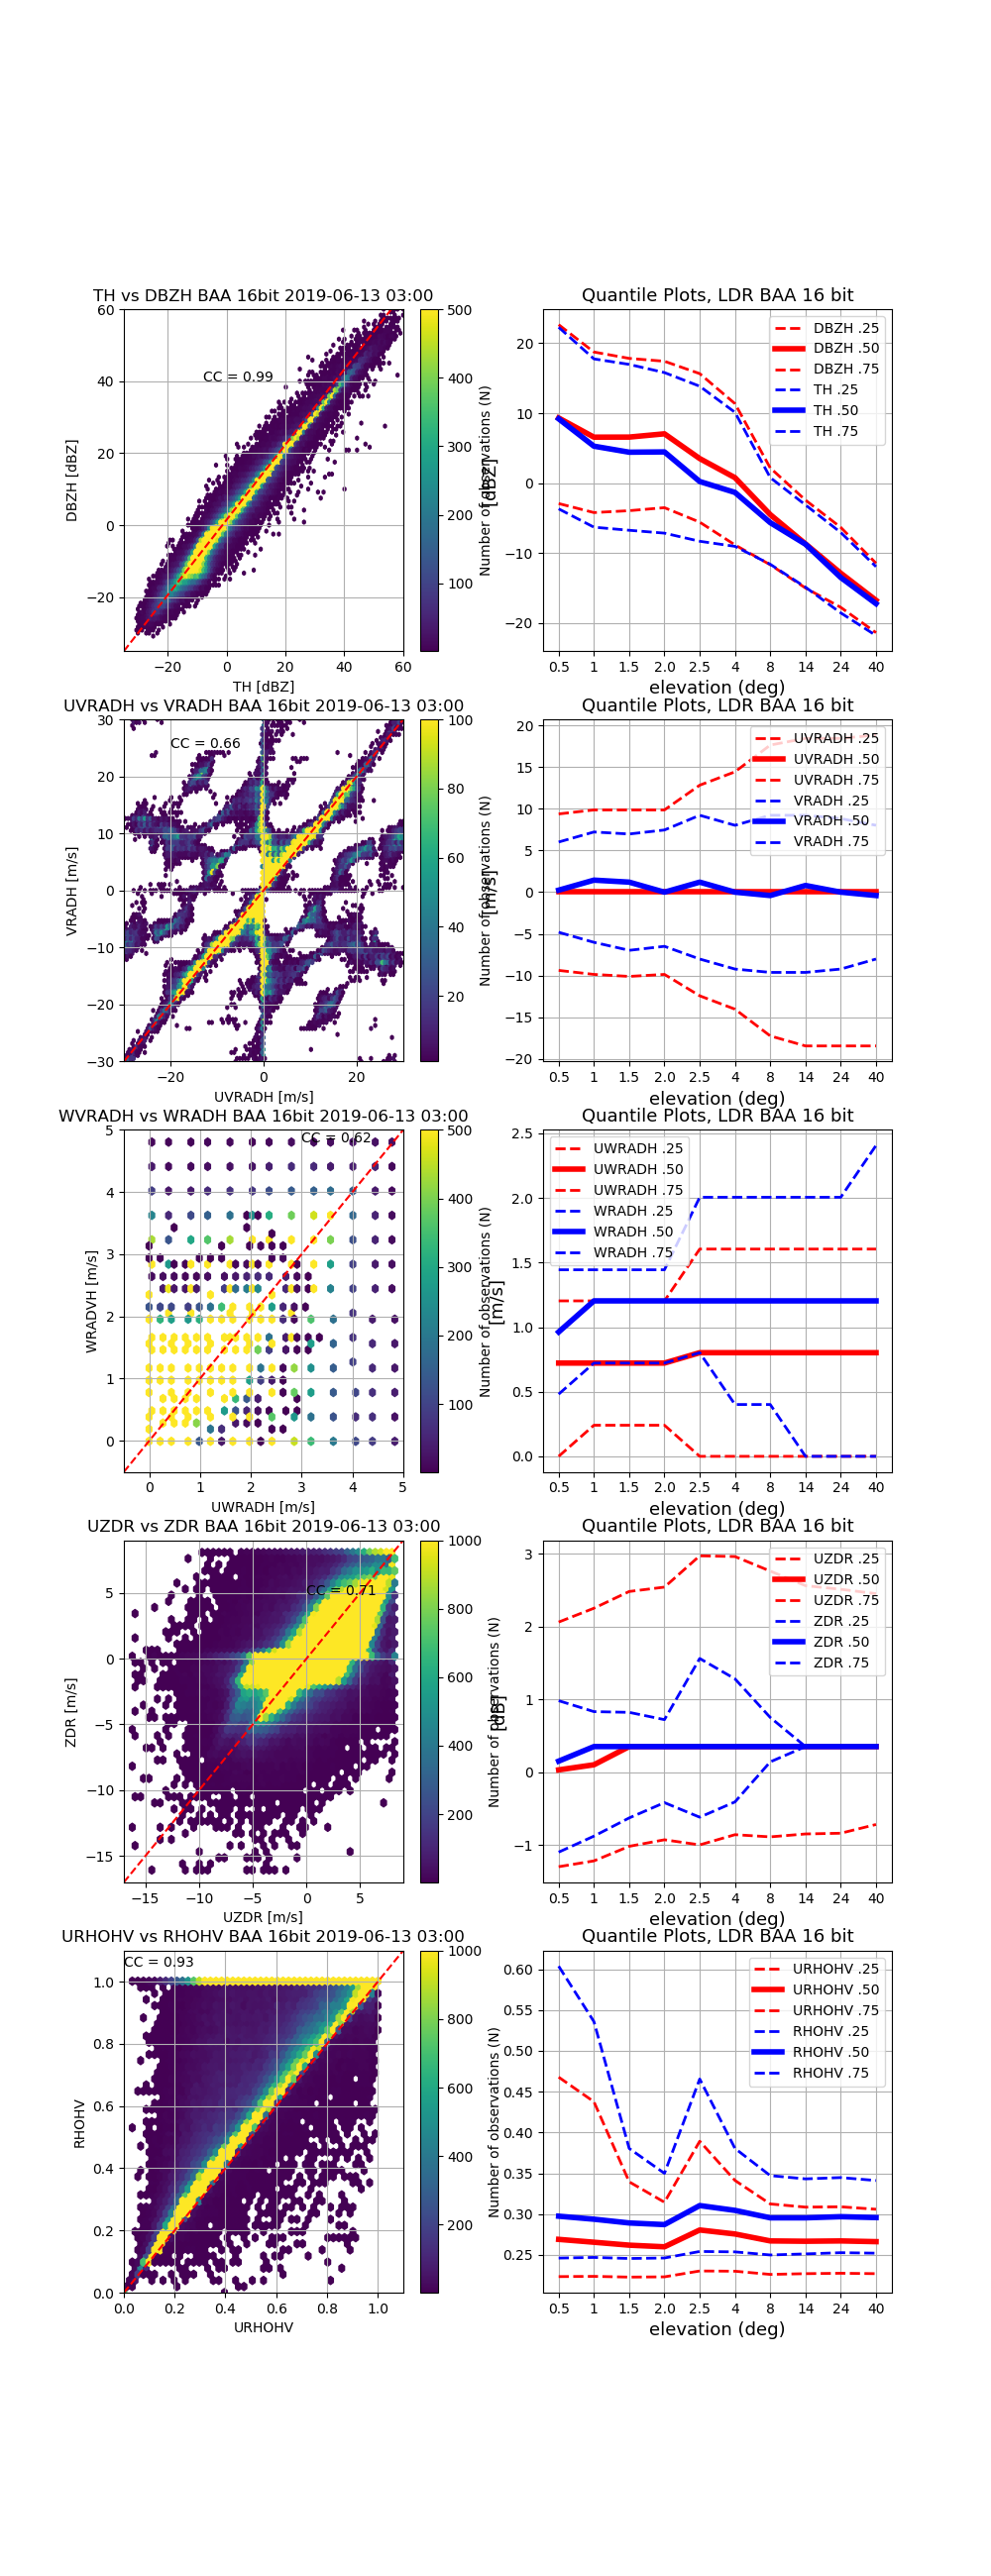

([<matplotlib.axis.XTick at 0x7f893c20e828>,
 <a list of 10 Text xticklabel objects>)

In [46]:
%matplotlib notebook

plt.figure(figsize=(10,26))

plt.subplot(5,2,1)
plt.hexbin(th_16_tot,dbzh_16_tot, mincnt=0.1,gridsize=100,extent=(-35,60,-35,60),vmax=500)
plt.grid()
plt.plot([-35,56],[-35,60],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH BAA 16bit 2019-06-13 03:00')
a=th_16_tot
b=dbzh_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))


range_interval=[1,2,3,4,5,6,7,8,9,10]
plt.subplot(5,2,2)
plt.plot(range_interval,quant_dbzh_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_dbzh_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_dbzh_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_th_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_th_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_th_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=13)
plt.ylabel('[dBZ]', fontsize=13)
plt.grid(True)
plt.title('Quantile Plots, LDR BAA 16 bit', fontsize=13)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
labels=['0.5','1','1.5','2.0','2.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,3)
plt.hexbin(uv_16_tot,v_16_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH BAA 16bit 2019-06-13 03:00')
a=uv_16_tot
b=v_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))


plt.subplot(5,2,4)
plt.plot(range_interval,quant_uv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_v_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=13)
plt.ylabel('[m/s]', fontsize=13)
plt.grid(True)
plt.title('Quantile Plots, LDR BAA 16 bit', fontsize=13)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
labels=['0.5','1','1.5','2.0','2.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,5)
plt.hexbin(uw_16_tot,w_16_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADVH [m/s]')
plt.title('WVRADH vs WRADH BAA 16bit 2019-06-13 03:00')
a=uw_16_tot
b=w_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))


plt.subplot(5,2,6)
plt.plot(range_interval,quant_uw_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_w_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=13)
plt.ylabel('[m/s]', fontsize=13)
plt.grid(True)
plt.title('Quantile Plots, LDR BAA 16 bit', fontsize=13)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
labels=['0.5','1','1.5','2.0','2.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,7)
plt.hexbin(uzdr_16_tot,zdr_16_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR BAA 16bit 2019-06-13 03:00')
a=uzdr_16_tot
b=zdr_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))


plt.subplot(5,2,8)
plt.plot(range_interval,quant_uzdr_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=13)
plt.ylabel('[dB]', fontsize=13)
plt.grid(True)
plt.title('Quantile Plots, LDR BAA 16 bit', fontsize=13)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
labels=['0.5','1','1.5','2.0','2.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,9)
plt.hexbin(urhohv_16_tot,rhohv_16_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=1000)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV BAA 16bit 2019-06-13 03:00')
a=urhohv_16_tot
b=rhohv_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))


plt.subplot(5,2,10)
plt.plot(range_interval,quant_urhohv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=13)
#plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR BAA 16 bit', fontsize=13)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['0.5','1','1.5','2.0','2.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)



### Hemse

In [47]:
#Hemse
file1 = file2_hem_16bit
file2 = file2_hem_8bit

#'data1': TH
#'data2': DBZH 
#'data23': UVRADH
#'data14': VRADH
#'data25': UWRADH
#'data16': WRADH
#'data18': UZDR
#'data5': ZDR

[th_16_tot, quant_th_16]=allelev_mom(file1,'data1')
[dbzh_16_tot, quant_dbzh_16]=allelev_mom(file1,'data2')
[uv_16_tot, quant_uv_16]=allelev_mom(file1,'data23')
[v_16_tot, quant_v_16]=allelev_mom(file1,'data14')
[uw_16_tot, quant_uw_16]=allelev_mom(file1,'data25')
[w_16_tot, quant_w_16]=allelev_mom(file1,'data16')
[uzdr_16_tot, quant_uzdr_16]=allelev_mom(file1,'data18')
[zdr_16_tot, quant_zdr_16]=allelev_mom(file1,'data5')
[urhohv_16_tot, quant_urhohv_16]=allelev_mom(file1,'data19')
[rhohv_16_tot, quant_rhohv_16]=allelev_mom(file1,'data6')

[th_8_tot, quant_th_8]=allelev_mom(file2,'data1')
[dbzh_8_tot, quant_dbzh_8]=allelev_mom(file2,'data2')
[uv_8_tot, quant_uv_8]=allelev_mom(file2,'data23')
[v_8_tot, quant_v_8]=allelev_mom(file2,'data14')
[uw_8_tot, quant_uw_8]=allelev_mom(file2,'data25')
[w_8_tot, quant_w_8]=allelev_mom(file2,'data16')
[uzdr_8_tot, quant_uzdr_8]=allelev_mom(file2,'data18')
[zdr_8_tot, quant_zdr_8]=allelev_mom(file2,'data5')
[urhohv_8_tot, quant_urhohv_8]=allelev_mom(file2,'data19')
[rhohv_8_tot, quant_rhohv_8]=allelev_mom(file2,'data6')

<IPython.core.display.Javascript object>


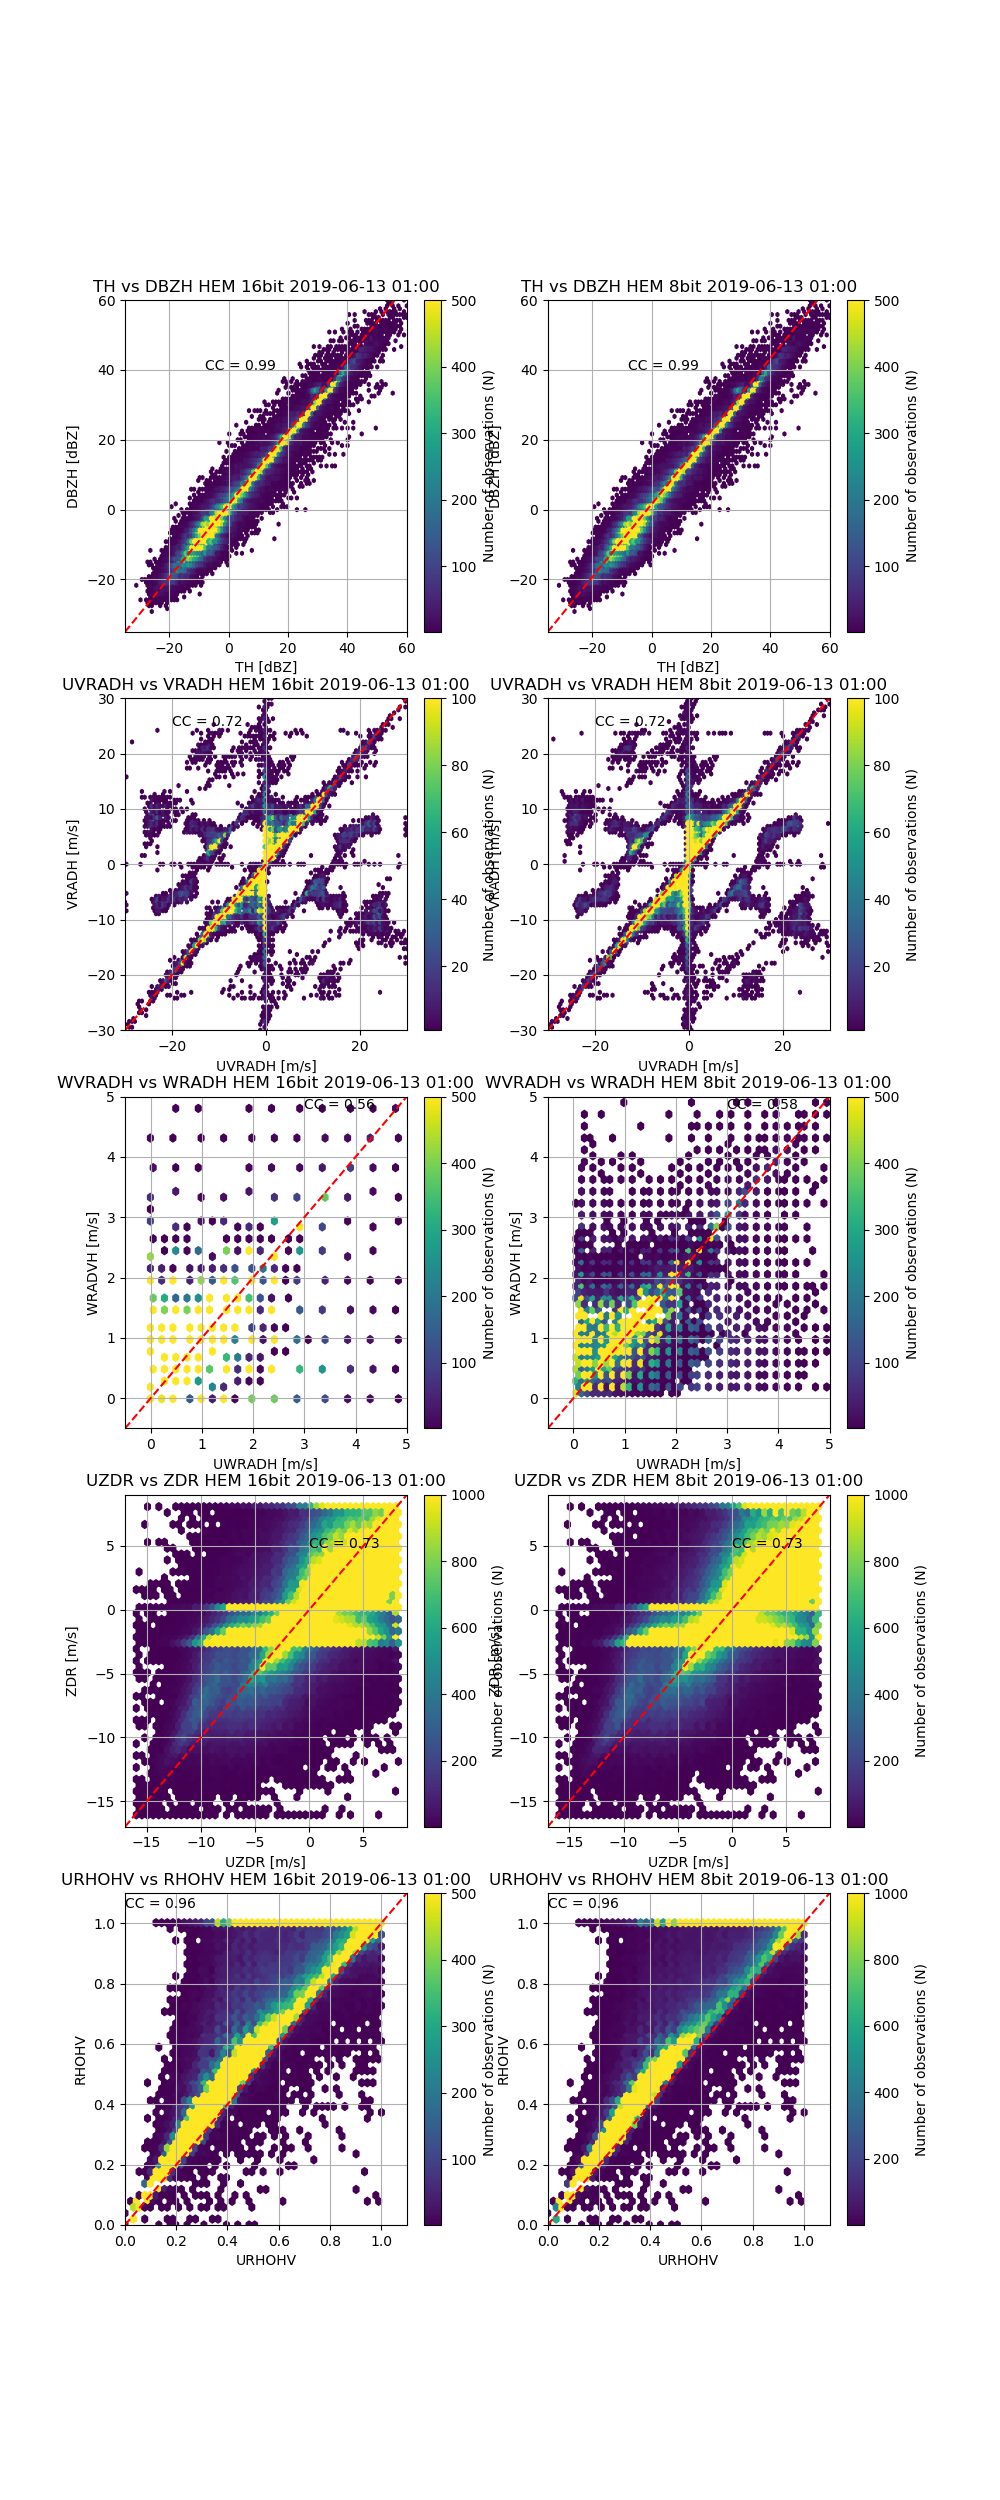

Text(0, 1.05, 'CC = 0.96')

In [48]:
%matplotlib notebook

plt.figure(figsize=(10,25))

plt.subplot(5,2,1)
plt.hexbin(th_16_tot,dbzh_16_tot, mincnt=0.1,gridsize=100,extent=(-35,60,-35,60),vmax=500)
plt.grid()
plt.plot([-35,56],[-35,60],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH HEM 16bit 2019-06-13 01:00')
a=th_16_tot
b=dbzh_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))


plt.subplot(5,2,2)
plt.hexbin(th_8_tot,dbzh_8_tot, mincnt=0.1,gridsize=100,extent=(-35,60,-35,60),vmax=500)
plt.grid()
plt.plot([-35,56],[-35,60],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH HEM 8bit 2019-06-13 01:00')
a=th_8_tot
b=dbzh_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))


plt.subplot(5,2,3)
plt.hexbin(uv_16_tot,v_16_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH HEM 16bit 2019-06-13 01:00')
a=uv_16_tot
b=v_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))


plt.subplot(5,2,4)
plt.hexbin(uv_8_tot,v_8_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH HEM 8bit 2019-06-13 01:00')
a=uv_8_tot
b=v_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))


plt.subplot(5,2,5)
plt.hexbin(uw_16_tot,w_16_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADVH [m/s]')
plt.title('WVRADH vs WRADH HEM 16bit 2019-06-13 01:00')
a=uw_16_tot
b=w_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))


plt.subplot(5,2,6)
plt.hexbin(uw_8_tot,w_8_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADVH [m/s]')
plt.title('WVRADH vs WRADH HEM 8bit 2019-06-13 01:00')
a=uw_8_tot
b=w_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))


plt.subplot(5,2,7)
plt.hexbin(uzdr_16_tot,zdr_16_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR HEM 16bit 2019-06-13 01:00')
a=uzdr_16_tot
b=zdr_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))


plt.subplot(5,2,8)
plt.hexbin(uzdr_8_tot,zdr_8_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR HEM 8bit 2019-06-13 01:00')
a=uzdr_8_tot
b=zdr_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))


plt.subplot(5,2,9)
plt.hexbin(urhohv_16_tot,rhohv_16_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=500)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV HEM 16bit 2019-06-13 01:00')
a=urhohv_16_tot
b=rhohv_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))


plt.subplot(5,2,10)
plt.hexbin(urhohv_8_tot,rhohv_8_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=1000)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV HEM 8bit 2019-06-13 01:00')
a=urhohv_8_tot
b=rhohv_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))

<IPython.core.display.Javascript object>


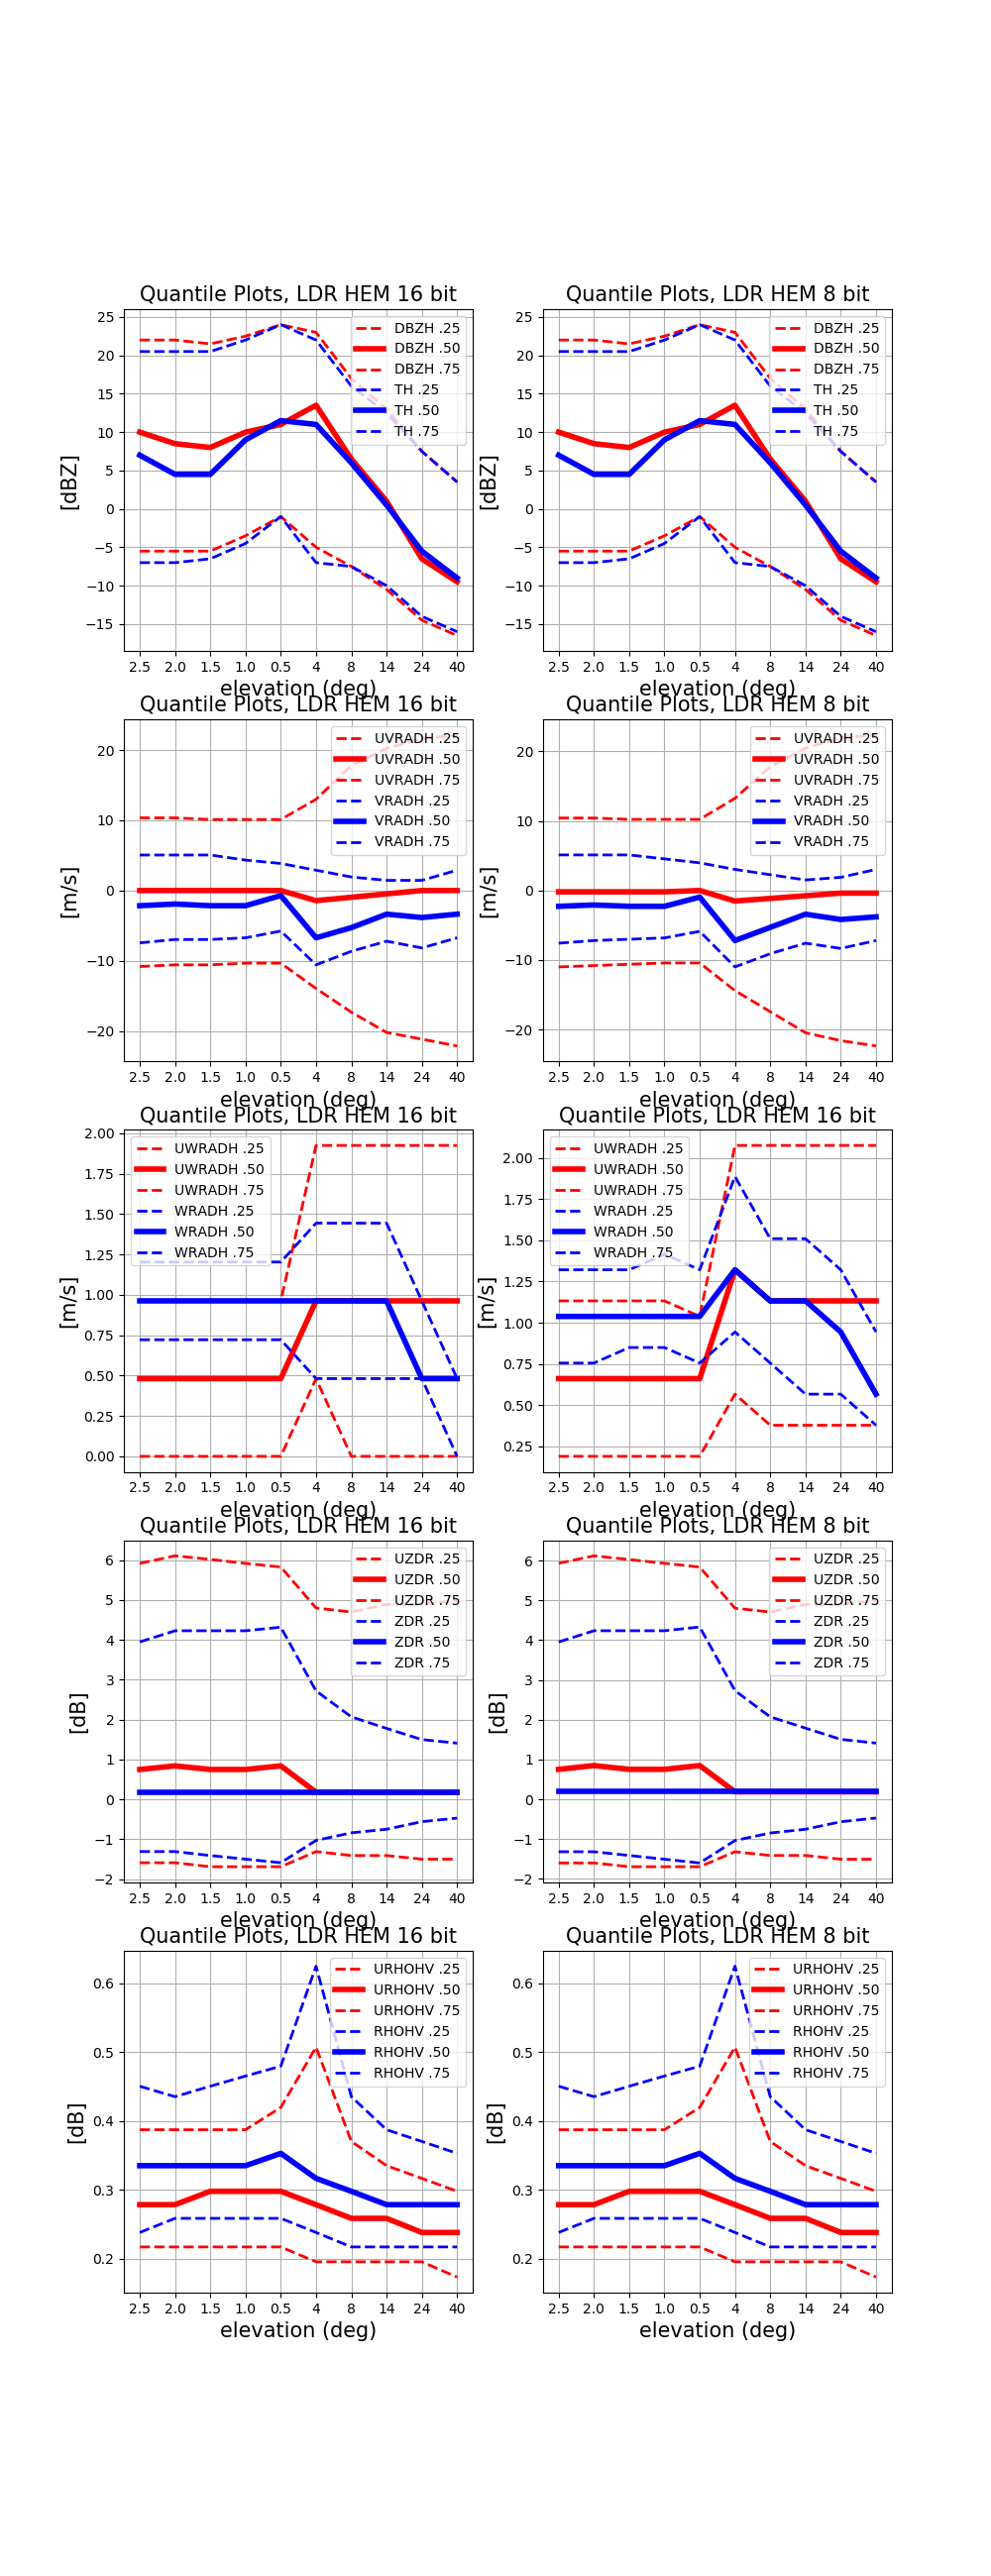

([<matplotlib.axis.XTick at 0x7f893b1b9d30>,
 <a list of 10 Text xticklabel objects>)

In [50]:
%matplotlib notebook

plt.figure(figsize=(10,26))
range_interval=[1,2,3,4,5,6,7,8,9,10]

plt.subplot(5,2,1)
plt.plot(range_interval,quant_dbzh_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_dbzh_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_dbzh_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_th_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_th_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_th_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dBZ]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 16 bit', fontsize=15)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,2)
plt.plot(range_interval,quant_dbzh_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_dbzh_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_dbzh_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_th_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_th_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_th_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dBZ]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 8 bit', fontsize=15)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,3)
plt.plot(range_interval,quant_uv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_v_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 16 bit', fontsize=15)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,4)
plt.plot(range_interval,quant_uv_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_v_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 8 bit', fontsize=15)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,5)
plt.plot(range_interval,quant_uw_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_w_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 16 bit', fontsize=15)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,6)
plt.plot(range_interval,quant_uw_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_w_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 16 bit', fontsize=15)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,7)
plt.plot(range_interval,quant_uzdr_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 16 bit', fontsize=15)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,8)
plt.plot(range_interval,quant_uzdr_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_zdr_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 8 bit', fontsize=15)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,9)
plt.plot(range_interval,quant_urhohv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 16 bit', fontsize=15)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,10)
plt.plot(range_interval,quant_urhohv_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR HEM 8 bit', fontsize=15)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)

### Karlskrona

In [51]:
#Karlskrona
file1 = file2_kaa_16bit
file2 = file2_kaa_8bit

#'data1': TH
#'data2': DBZH 
#'data23': UVRADH
#'data14': VRADH
#'data25': UWRADH
#'data16': WRADH
#'data18': UZDR
#'data5': ZDR
#'data19': URHOHV
#'data6': RHOHV

[th_16_tot, quant_th_16]=allelev_mom(file1,'data1')
[dbzh_16_tot, quant_dbzh_16]=allelev_mom(file1,'data2')
[uv_16_tot, quant_uv_16]=allelev_mom(file1,'data23')
[v_16_tot, quant_v_16]=allelev_mom(file1,'data14')
[uw_16_tot, quant_uw_16]=allelev_mom(file1,'data25')
[w_16_tot, quant_w_16]=allelev_mom(file1,'data16')
[uzdr_16_tot, quant_uzdr_16]=allelev_mom(file1,'data18')
[zdr_16_tot, quant_zdr_16]=allelev_mom(file1,'data5')
[urhohv_16_tot, quant_urhohv_16]=allelev_mom(file1,'data19')
[rhohv_16_tot, quant_rhohv_16]=allelev_mom(file1,'data6')

[th_8_tot, quant_th_8]=allelev_mom(file2,'data1')
[dbzh_8_tot, quant_dbzh_8]=allelev_mom(file2,'data2')
[uv_8_tot, quant_uv_8]=allelev_mom(file2,'data23')
[v_8_tot, quant_v_8]=allelev_mom(file2,'data14')
[uw_8_tot, quant_uw_8]=allelev_mom(file2,'data25')
[w_8_tot, quant_w_8]=allelev_mom(file2,'data16')
[uzdr_8_tot, quant_uzdr_8]=allelev_mom(file2,'data18')
[zdr_8_tot, quant_zdr_8]=allelev_mom(file2,'data5')
[urhohv_8_tot, quant_urhohv_8]=allelev_mom(file2,'data19')
[rhohv_8_tot, quant_rhohv_8]=allelev_mom(file2,'data6')

<IPython.core.display.Javascript object>


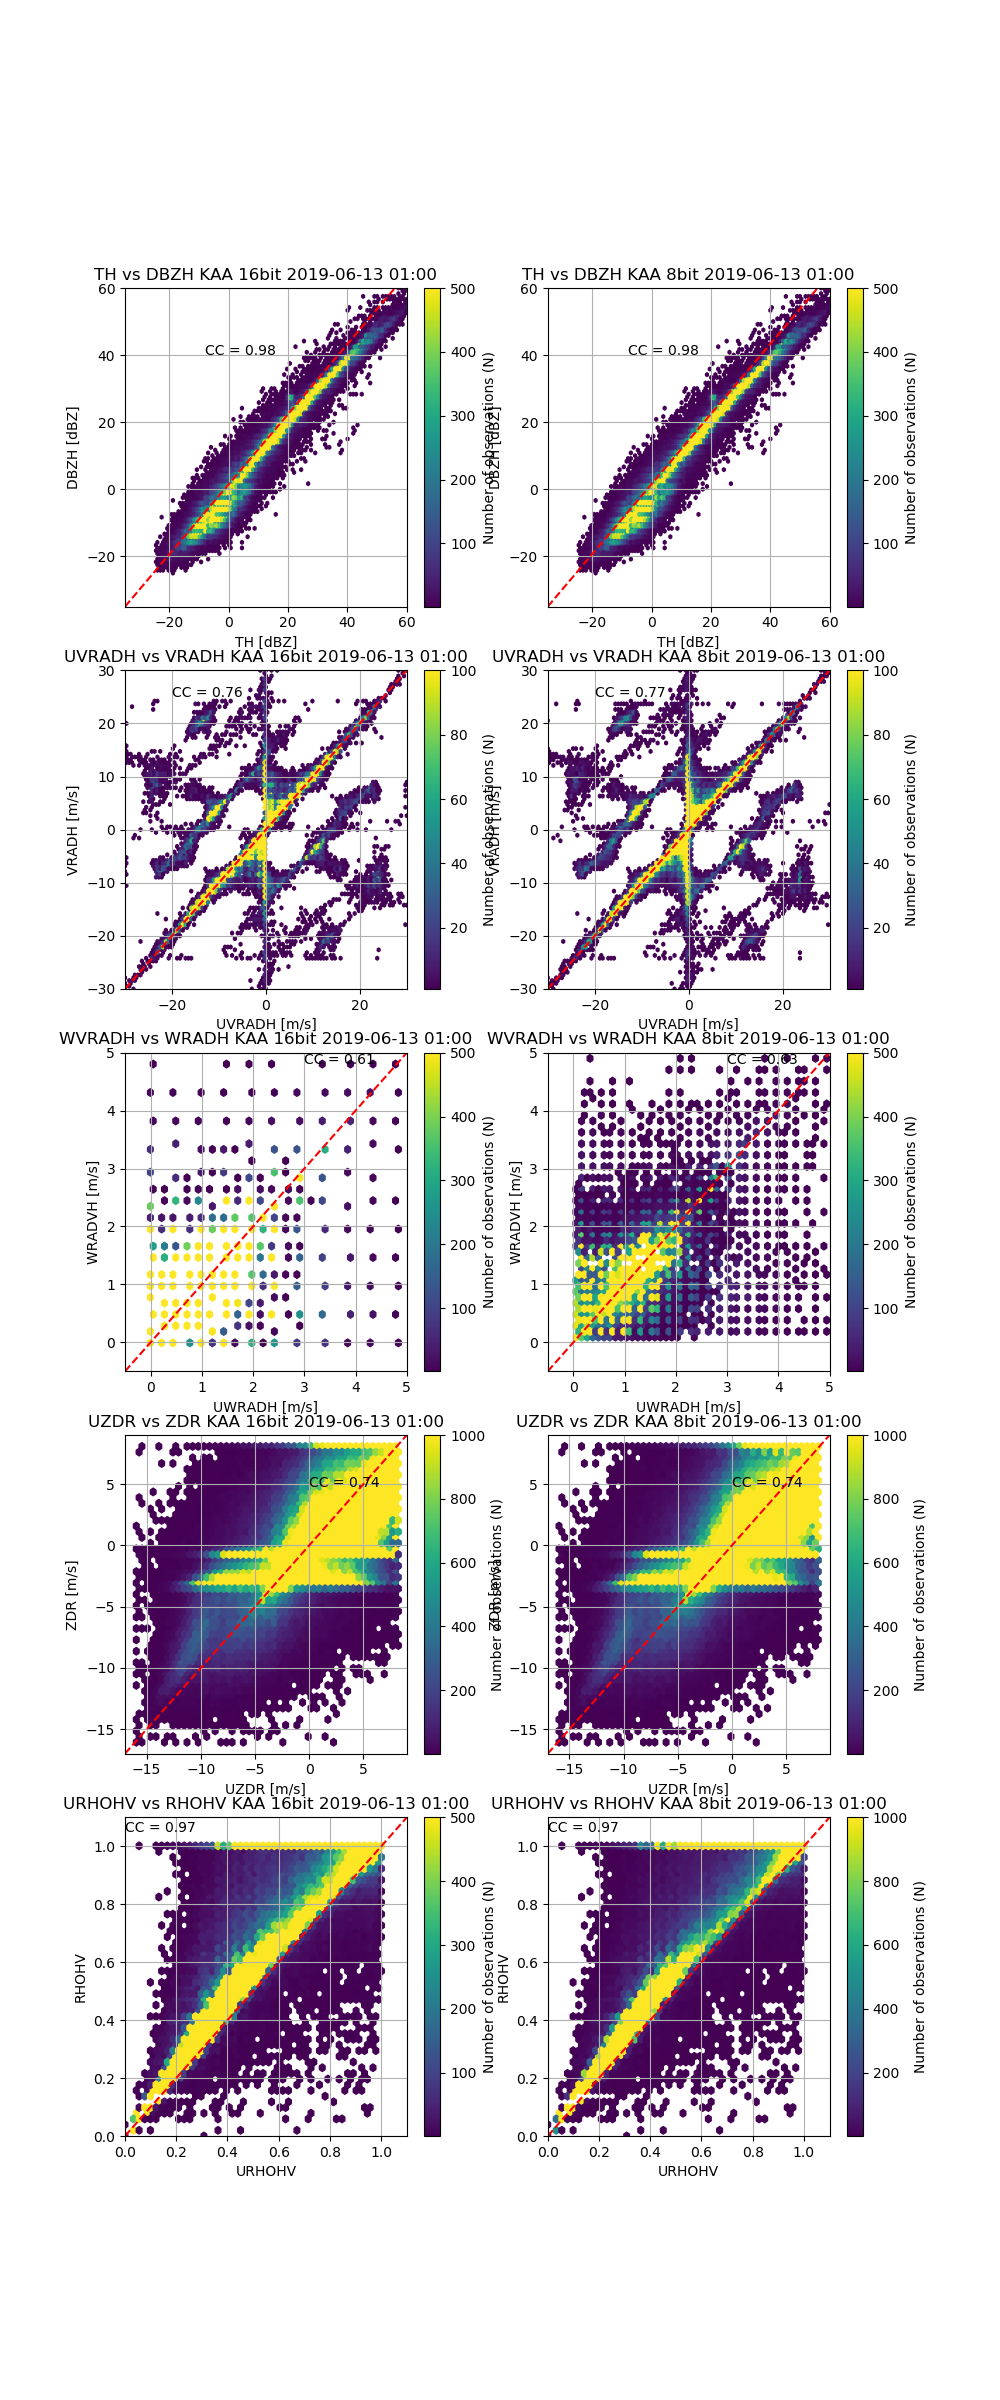

Text(0, 1.05, 'CC = 0.97')

In [53]:
%matplotlib notebook

plt.figure(figsize=(10,24))

plt.subplot(5,2,1)
plt.hexbin(th_16_tot,dbzh_16_tot, mincnt=0.1,gridsize=100,extent=(-35,60,-35,60),vmax=500)
plt.grid()
plt.plot([-35,56],[-35,60],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH KAA 16bit 2019-06-13 01:00')
a=th_16_tot
b=dbzh_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))


plt.subplot(5,2,2)
plt.hexbin(th_8_tot,dbzh_8_tot, mincnt=0.1,gridsize=100,extent=(-35,60,-35,60),vmax=500)
plt.grid()
plt.plot([-35,56],[-35,60],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('TH [dBZ]')
plt.ylabel('DBZH [dBZ]')
plt.title('TH vs DBZH KAA 8bit 2019-06-13 01:00')
a=th_8_tot
b=dbzh_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-8,40))


plt.subplot(5,2,3)
plt.hexbin(uv_16_tot,v_16_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH KAA 16bit 2019-06-13 01:00')
a=uv_16_tot
b=v_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))


plt.subplot(5,2,4)
plt.hexbin(uv_8_tot,v_8_tot, mincnt=0.1,gridsize=100,extent=(-30,30,-30,30),vmax=100)
plt.grid()
plt.plot([-30,30],[-30,30],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UVRADH [m/s]')
plt.ylabel('VRADH [m/s]')
plt.title('UVRADH vs VRADH KAA 8bit 2019-06-13 01:00')
a=uv_8_tot
b=v_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(-20,25))


plt.subplot(5,2,5)
plt.hexbin(uw_16_tot,w_16_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADVH [m/s]')
plt.title('WVRADH vs WRADH KAA 16bit 2019-06-13 01:00')
a=uw_16_tot
b=w_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))


plt.subplot(5,2,6)
plt.hexbin(uw_8_tot,w_8_tot, mincnt=0.1,gridsize=50,extent=(-0.5,5,-0.5,5),vmax=500)
plt.grid()
plt.plot([-0.5,5],[-0.5,5],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UWRADH [m/s]')
plt.ylabel('WRADVH [m/s]')
plt.title('WVRADH vs WRADH KAA 8bit 2019-06-13 01:00')
a=uw_8_tot
b=w_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(3,4.8))


plt.subplot(5,2,7)
plt.hexbin(uzdr_16_tot,zdr_16_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR KAA 16bit 2019-06-13 01:00')
a=uzdr_16_tot
b=zdr_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))


plt.subplot(5,2,8)
plt.hexbin(uzdr_8_tot,zdr_8_tot, mincnt=0.1,gridsize=50,extent=(-17,9,-17,9),vmax=1000)
plt.grid()
plt.plot([-17,9],[-17,9],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('UZDR [m/s]')
plt.ylabel('ZDR [m/s]')
plt.title('UZDR vs ZDR KAA 8bit 2019-06-13 01:00')
a=uzdr_8_tot
b=zdr_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,4.8))


plt.subplot(5,2,9)
plt.hexbin(urhohv_16_tot,rhohv_16_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=500)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV KAA 16bit 2019-06-13 01:00')
a=urhohv_16_tot
b=rhohv_16_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))


plt.subplot(5,2,10)
plt.hexbin(urhohv_8_tot,rhohv_8_tot, mincnt=0.1,gridsize=50,extent=(0,1.1,0,1.1),vmax=1000)
plt.grid()
plt.plot([0,1.1],[0,1.1],'r--')
plt.colorbar(label='Number of observations (N)')
plt.xlabel('URHOHV')
plt.ylabel('RHOHV')
plt.title('URHOHV vs RHOHV KAA 8bit 2019-06-13 01:00')
a=urhohv_8_tot
b=rhohv_8_tot
bad = ~np.logical_or(np.isnan(a), np.isnan(b))
a= a[bad]
b= b[bad]
cc=np.corrcoef(a,b)[0, 1]
plt.annotate('CC = {:.2}'.format(cc),(0,1.05))

<IPython.core.display.Javascript object>


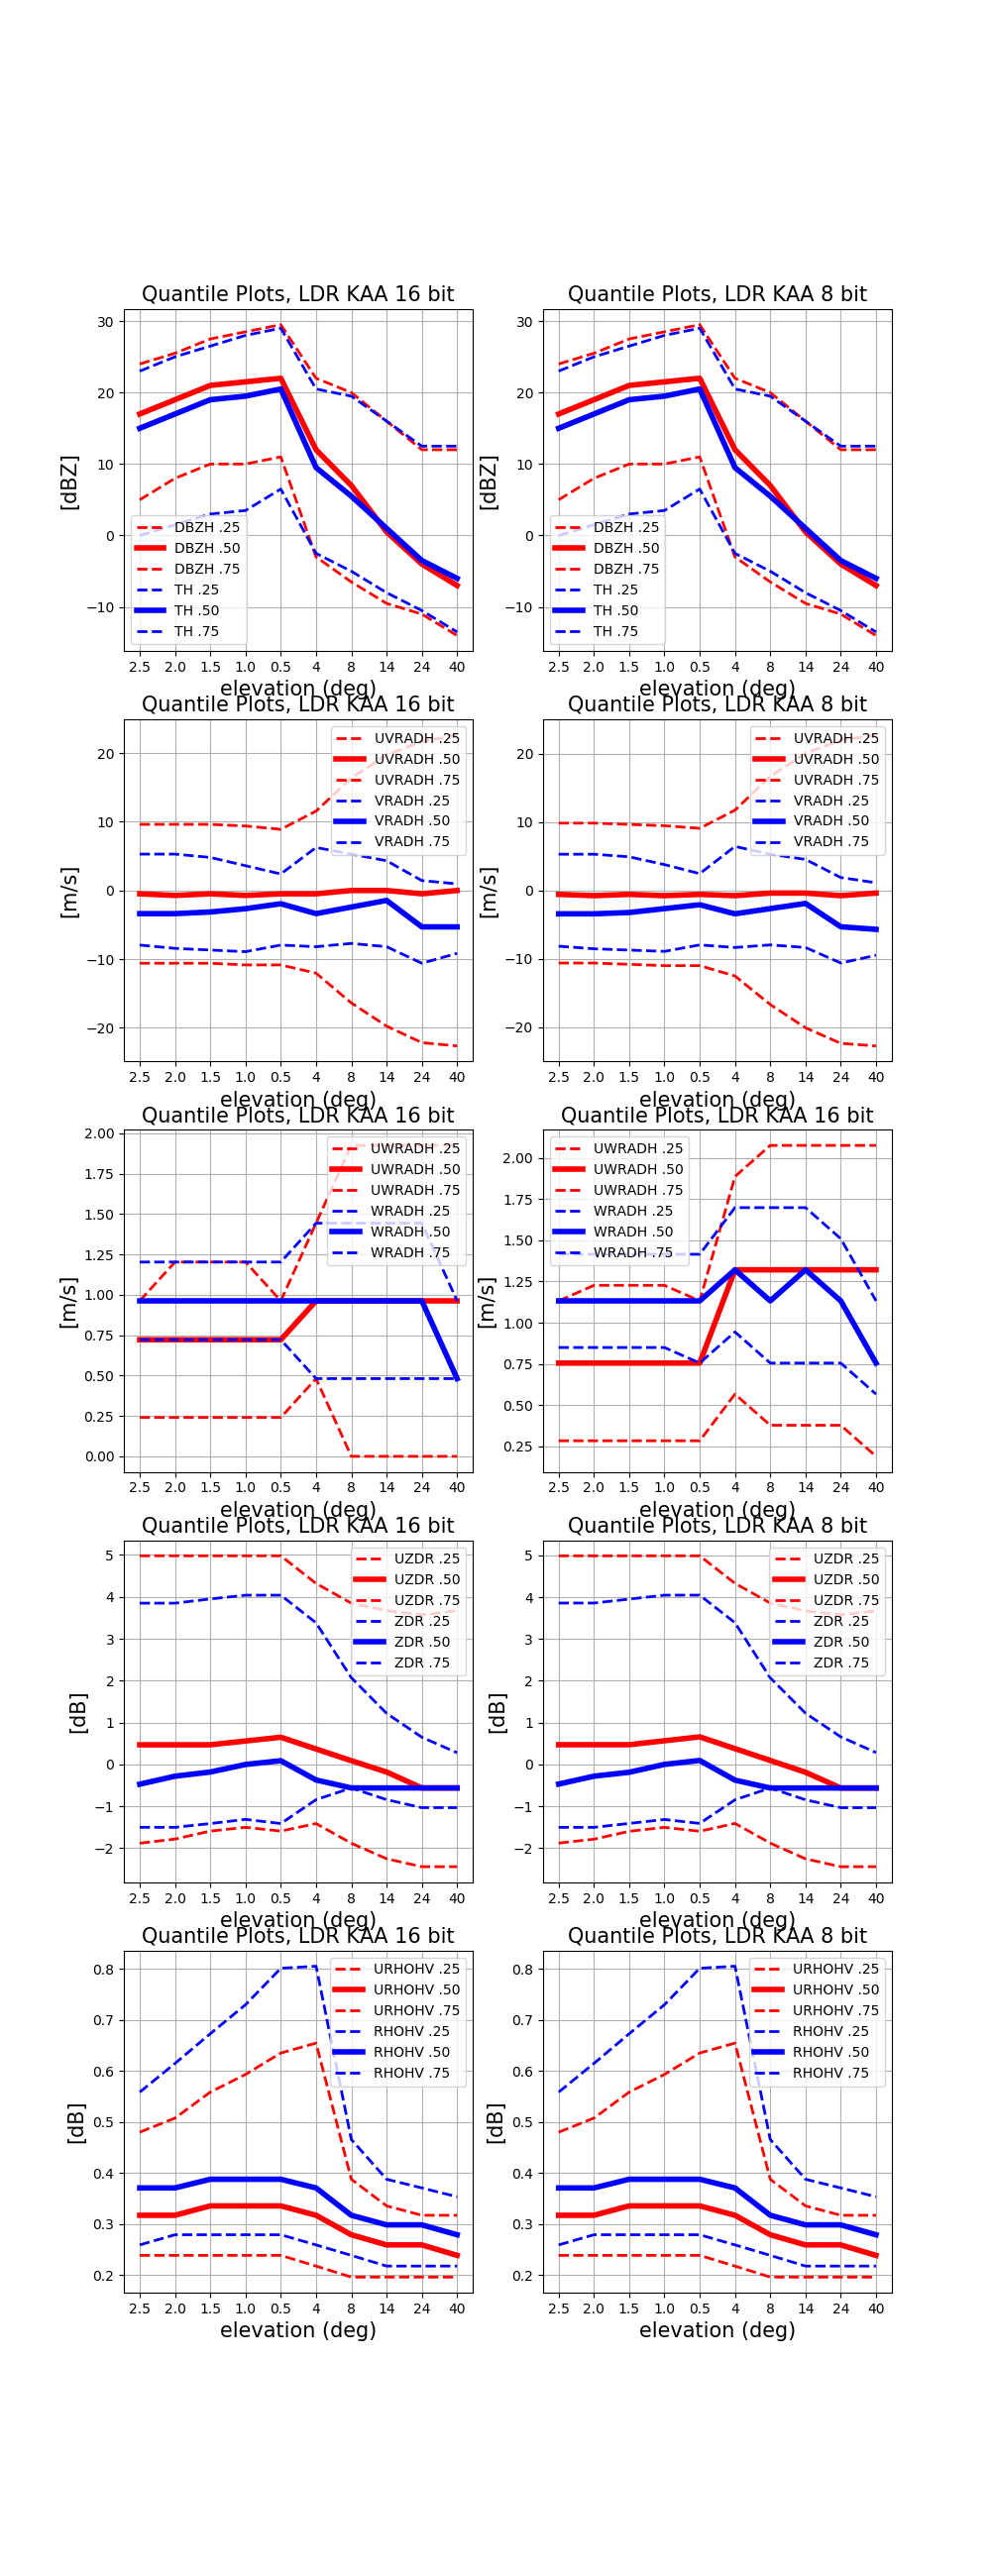

([<matplotlib.axis.XTick at 0x7f893a13bda0>,
 <a list of 10 Text xticklabel objects>)

In [54]:
%matplotlib notebook

range_interval=[1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(10,26))

plt.subplot(5,2,1)
plt.plot(range_interval,quant_dbzh_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_dbzh_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_dbzh_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_th_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_th_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_th_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dBZ]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 16 bit', fontsize=15)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,2)
plt.plot(range_interval,quant_dbzh_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_dbzh_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_dbzh_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_th_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_th_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_th_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dBZ]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 8 bit', fontsize=15)
plt.legend(['DBZH .25','DBZH .50','DBZH .75','TH .25','TH .50','TH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,3)
plt.plot(range_interval,quant_uv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_v_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 16 bit', fontsize=15)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,4)
plt.plot(range_interval,quant_uv_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uv_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uv_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_v_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_v_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_v_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 8 bit', fontsize=15)
plt.legend(['UVRADH .25','UVRADH .50','UVRADH .75','VRADH .25','VRADH .50','VRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,5)
plt.plot(range_interval,quant_uw_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_w_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 16 bit', fontsize=15)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,6)
plt.plot(range_interval,quant_uw_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uw_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uw_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_w_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_w_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_w_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[m/s]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 16 bit', fontsize=15)
plt.legend(['UWRADH .25','UWRADH .50','UWRADH .75','WRADH .25','WRADH .50','WRADH .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,7)
plt.plot(range_interval,quant_uzdr_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 16 bit', fontsize=15)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,8)
plt.plot(range_interval,quant_uzdr_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_uzdr_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_uzdr_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_zdr_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_zdr_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_zdr_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 8 bit', fontsize=15)
plt.legend(['UZDR .25','UZDR .50','UZDR .75','ZDR .25','ZDR .50','ZDR .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,9)
plt.plot(range_interval,quant_urhohv_16[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_16[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_16[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_16[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_16[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 16 bit', fontsize=15)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)


plt.subplot(5,2,10)
plt.plot(range_interval,quant_urhohv_8[:,0],'--r',linewidth=2)
plt.plot(range_interval,quant_urhohv_8[:,1],'r',linewidth=4)
plt.plot(range_interval,quant_urhohv_8[:,2],'--r',linewidth=2)
plt.plot(range_interval,quant_rhohv_8[:,0],'--b',linewidth=2)
plt.plot(range_interval,quant_rhohv_8[:,1],'b',linewidth=4)
plt.plot(range_interval,quant_rhohv_8[:,2],'--b',linewidth=2)
plt.xlabel('elevation (deg)', fontsize=15)
plt.ylabel('[dB]', fontsize=15)
plt.grid(True)
plt.title('Quantile Plots, LDR KAA 8 bit', fontsize=15)
plt.legend(['URHOHV .25','URHOHV .50','URHOHV .75','RHOHV .25','RHOHV .50','RHOHV .75'])
labels=['2.5','2.0','1.5','1.0','0.5','4','8','14','24','40']
plt.xticks(range(1,11),labels)